In [ ]:
%load_ext lab_black

In [ ]:
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import io
from pydub import AudioSegment

# from python_speech_features import mfcc as mfcc2
# from python_speech_features import fbank as fbank2
# from python_speech_features import delta
# from python_speech_features import logfbank
# from python_speech_features import fbank, get_filterbanks
from scipy.io.wavfile import write
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# import librosa
from scipy.io import wavfile
from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from genetic_selection import GeneticSelectionCV
import numpy
from sklearn.model_selection import cross_val_score
from collections import defaultdict
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import confusion_matrix
# from python_speech_features import sigproc

Dibawah adalah fungsi-fungsi yang digunakan.
mfcc adalah mfcc yang diubah ROI nya
mfcc2 adalah default mfcc

In [ ]:
from python_speech_features import sigproc
from scipy.fftpack import dct


def calculate_nfft(samplerate, winlen):
    """Calculates the FFT size as a power of two greater than or equal to
    the number of samples in a single window length.

    Having an FFT less than the window length loses precision by dropping
    many of the samples; a longer FFT than the window allows zero-padding
    of the FFT buffer which is neutral in terms of frequency domain conversion.
    :param samplerate: The sample rate of the signal we are working with, in Hz.
    :param winlen: The length of the analysis window in seconds.
    """
    window_length_samples = winlen * samplerate
    nfft = 1
    while nfft < window_length_samples:
        nfft *= 2
    return nfft


def mfcc(
    signal,
    samplerate=16000,
    winlen=0.025,
    winstep=0.01,
    numcep=13,
    nfilt=13,
    nfft=None,
    preemph=0.97,
    ceplifter=22,
    appendEnergy=True,
    lower_superset=0,
    higher_superset=1000,
    lower_roi=333,
    higher_roi=666,
    factor_b=1,
    winfunc=lambda x: np.ones((x,)),
):
    """Compute MFCC features from an audio signal.
    :param signal: the audio signal from which to compute features. Should be an N*1 array
    :param samplerate: the sample rate of the signal we are working with, in Hz.
    :param winlen: the length of the analysis window in seconds. Default is 0.025s (25 milliseconds)
    :param winstep: the step between successive windows in seconds. Default is 0.01s (10 milliseconds)
    :param numcep: the number of cepstrum to return, default 13
    :param nfilt: the number of filters in the filterbank, default 26.
    :param nfft: the FFT size. Default is None, which uses the calculate_nfft function to choose the smallest size that does not drop sample data.
    :param lowfreq: lowest band edge of mel filters. In Hz, default is 0.
    :param highfreq: highest band edge of mel filters. In Hz, default is samplerate/2
    :param preemph: apply preemphasis filter with preemph as coefficient. 0 is no filter. Default is 0.97.
    :param ceplifter: apply a lifter to final cepstral coefficients. 0 is no lifter. Default is 22.
    :param appendEnergy: if this is true, the zeroth cepstral coefficient is replaced with the log of the total frame energy.
    :param winfunc: the analysis window to apply to each frame. By default no window is applied. You can use numpy window functions here e.g. winfunc=numpy.hamming
    :returns: A numpy array of size (NUMFRAMES by numcep) containing features. Each row holds 1 feature vector.
    """
    nfft = nfft or calculate_nfft(samplerate, winlen)
    feat, energy = fbank(
        signal,
        samplerate,
        winlen,
        winstep,
        nfilt,
        nfft,
        preemph,
        lower_superset,
        higher_superset,
        lower_roi,
        higher_roi,
        factor_b,
        winfunc,
    )
    #     feat2,energy2 = fbank2(signal,samplerate,winlen,winstep,nfilt,nfft,preemph,winfunc)
    #     print(feat2)
    #     print(feat)
    feat = np.log(feat)
    feat = dct(feat, type=2, axis=1, norm="ortho")[:, :numcep]
    feat = lifter(feat, ceplifter)
    if appendEnergy:
        feat[:, 0] = np.log(
            energy
        )  # replace first cepstral coefficient with log of frame energy
    return feat


def fbank(
    signal,
    samplerate=16000,
    winlen=0.025,
    winstep=0.01,
    nfilt=26,
    nfft=512,
    preemph=0.97,
    lower_superset=0,
    higher_superset=1000,
    lower_roi=333,
    higher_roi=666,
    factor_b=1,
    winfunc=lambda x: np.ones((x,)),
):
    """Compute Mel-filterbank energy features from an audio signal.
    :param signal: the audio signal from which to compute features. Should be an N*1 array
    :param samplerate: the sample rate of the signal we are working with, in Hz.
    :param winlen: the length of the analysis window in seconds. Default is 0.025s (25 milliseconds)
    :param winstep: the step between successive windows in seconds. Default is 0.01s (10 milliseconds)
    :param nfilt: the number of filters in the filterbank, default 26.
    :param nfft: the FFT size. Default is 512.
    :param lowfreq: lowest band edge of mel filters. In Hz, default is 0.
    :param highfreq: highest band edge of mel filters. In Hz, default is samplerate/2
    :param preemph: apply preemphasis filter with preemph as coefficient. 0 is no filter. Default is 0.97.
    :param winfunc: the analysis window to apply to each frame. By default no window is applied. You can use numpy window functions here e.g. winfunc=numpy.hamming
    :returns: 2 values. The first is a numpy array of size (NUMFRAMES by nfilt) containing features. Each row holds 1 feature vector. The
        second return value is the energy in each frame (total energy, unwindowed)
    """

    signal = sigproc.preemphasis(signal, preemph)
    frames = sigproc.framesig(
        signal, winlen * samplerate, winstep * samplerate, winfunc
    )
    pspec = sigproc.powspec(frames, nfft)
    energy = np.sum(pspec, 1)  # this stores the total energy in each frame
    energy = np.where(
        energy == 0, np.finfo(float).eps, energy
    )  # if energy is zero, we get problems with log

    filter_range_1 = np.linspace(hz2mel(lower_superset), hz2mel(higher_superset), nfilt)
    filter_range_2 = np.linspace(hz2mel(lower_roi), hz2mel(higher_roi), nfilt)

    #     print(lower_superset)
    #     print(higher_superset)
    #     print(lower_roi)
    #     print(higher_roi)
    #     print(filter_range_1)
    #     print(filter_range_2)

    n_filter_traditional = len(
        [
            x
            for x in filter_range_1
            if (x >= filter_range_2[0] and x <= filter_range_2[-1])
        ]
    )
    n_filter_modified = factor_b * n_filter_traditional

    for i, val in enumerate(filter_range_1):
        if val >= filter_range_2[0]:
            first_index = i
            break

    for i, val in enumerate(filter_range_1):
        if val > filter_range_2[-1]:
            second_index = i
            break

    fb = get_filterbanks(nfilt, nfft, samplerate, lower_superset, higher_superset)
    fb2 = get_filterbanks(n_filter_modified, nfft, samplerate, lower_roi, higher_roi)
    fb = np.concatenate([fb[:first_index], fb2, fb[second_index:]])
    feat = np.dot(pspec, fb.T)  # compute the filterbank energies
    feat = np.where(
        feat == 0, np.finfo(float).eps, feat
    )  # if feat is zero, we get problems with log

    return feat, energy


def logfbank(
    signal,
    samplerate=16000,
    winlen=0.025,
    winstep=0.01,
    nfilt=26,
    nfft=512,
    lowfreq=0,
    highfreq=None,
    preemph=0.97,
    winfunc=lambda x: np.ones((x,)),
):
    """Compute log Mel-filterbank energy features from an audio signal.
    :param signal: the audio signal from which to compute features. Should be an N*1 array
    :param samplerate: the sample rate of the signal we are working with, in Hz.
    :param winlen: the length of the analysis window in seconds. Default is 0.025s (25 milliseconds)
    :param winstep: the step between successive windows in seconds. Default is 0.01s (10 milliseconds)
    :param nfilt: the number of filters in the filterbank, default 26.
    :param nfft: the FFT size. Default is 512.
    :param lowfreq: lowest band edge of mel filters. In Hz, default is 0.
    :param highfreq: highest band edge of mel filters. In Hz, default is samplerate/2
    :param preemph: apply preemphasis filter with preemph as coefficient. 0 is no filter. Default is 0.97.
    :param winfunc: the analysis window to apply to each frame. By default no window is applied. You can use numpy window functions here e.g. winfunc=numpy.hamming
    :returns: A numpy array of size (NUMFRAMES by nfilt) containing features. Each row holds 1 feature vector.
    """
    feat, energy = fbank(
        signal,
        samplerate,
        winlen,
        winstep,
        nfilt,
        nfft,
        lowfreq,
        highfreq,
        preemph,
        winfunc,
    )
    return np.log(feat)


def ssc(
    signal,
    samplerate=16000,
    winlen=0.025,
    winstep=0.01,
    nfilt=26,
    nfft=512,
    lowfreq=0,
    highfreq=None,
    preemph=0.97,
    winfunc=lambda x: np.ones((x,)),
):
    """Compute Spectral Subband Centroid features from an audio signal.
    :param signal: the audio signal from which to compute features. Should be an N*1 array
    :param samplerate: the sample rate of the signal we are working with, in Hz.
    :param winlen: the length of the analysis window in seconds. Default is 0.025s (25 milliseconds)
    :param winstep: the step between successive windows in seconds. Default is 0.01s (10 milliseconds)
    :param nfilt: the number of filters in the filterbank, default 26.
    :param nfft: the FFT size. Default is 512.
    :param lowfreq: lowest band edge of mel filters. In Hz, default is 0.
    :param highfreq: highest band edge of mel filters. In Hz, default is samplerate/2
    :param preemph: apply preemphasis filter with preemph as coefficient. 0 is no filter. Default is 0.97.
    :param winfunc: the analysis window to apply to each frame. By default no window is applied. You can use numpy window functions here e.g. winfunc=numpy.hamming
    :returns: A numpy array of size (NUMFRAMES by nfilt) containing features. Each row holds 1 feature vector.
    """
    highfreq = highfreq or samplerate / 2
    signal = sigproc.preemphasis(signal, preemph)
    frames = sigproc.framesig(
        signal, winlen * samplerate, winstep * samplerate, winfunc
    )
    pspec = sigproc.powspec(frames, nfft)
    pspec = np.where(
        pspec == 0, np.finfo(float).eps, pspec
    )  # if things are all zeros we get problems

    fb = get_filterbanks(nfilt, nfft, samplerate, lowfreq, highfreq)
    feat = np.dot(pspec, fb.T)  # compute the filterbank energies
    R = np.tile(
        np.linspace(1, samplerate / 2, np.size(pspec, 1)), (np.size(pspec, 0), 1)
    )

    return np.dot(pspec * R, fb.T) / feat


def hz2mel(hz):
    """Convert a value in Hertz to Mels
    :param hz: a value in Hz. This can also be a numpy array, conversion proceeds element-wise.
    :returns: a value in Mels. If an array was passed in, an identical sized array is returned.
    """
    return 2595 * np.log10(1 + hz / 700.0)


def mel2hz(mel):
    """Convert a value in Mels to Hertz
    :param mel: a value in Mels. This can also be a np array, conversion proceeds element-wise.
    :returns: a value in Hertz. If an array was passed in, an identical sized array is returned.
    """
    return 700 * (10 ** (mel / 2595.0) - 1)


def get_filterbanks(nfilt=20, nfft=512, samplerate=16000, lowfreq=0, highfreq=None):
    """Compute a Mel-filterbank. The filters are stored in the rows, the columns correspond
    to fft bins. The filters are returned as an array of size nfilt * (nfft/2 + 1)
    :param nfilt: the number of filters in the filterbank, default 20.
    :param nfft: the FFT size. Default is 512.
    :param samplerate: the sample rate of the signal we are working with, in Hz. Affects mel spacing.
    :param lowfreq: lowest band edge of mel filters, default 0 Hz
    :param highfreq: highest band edge of mel filters, default samplerate/2
    :returns: A np array of size nfilt * (nfft/2 + 1) containing filterbank. Each row holds 1 filter.
    """
    highfreq = highfreq or samplerate / 2
    assert highfreq <= samplerate / 2, "highfreq is greater than samplerate/2"

    # compute points evenly spaced in mels
    lowmel = hz2mel(lowfreq)
    highmel = hz2mel(highfreq)
    melpoints = np.linspace(lowmel, highmel, nfilt + 2)
    # our points are in Hz, but we use fft bins, so we have to convert
    #  from Hz to fft bin number
    bin = np.floor((nfft + 1) * mel2hz(melpoints) / samplerate)

    fbank = np.zeros([nfilt, nfft // 2 + 1])
    for j in range(0, nfilt):
        for i in range(int(bin[j]), int(bin[j + 1])):
            fbank[j, i] = (i - bin[j]) / (bin[j + 1] - bin[j])
        for i in range(int(bin[j + 1]), int(bin[j + 2])):
            fbank[j, i] = (bin[j + 2] - i) / (bin[j + 2] - bin[j + 1])
    return fbank


def lifter(cepstra, L=22):
    """Apply a cepstral lifter the the matrix of cepstra. This has the effect of increasing the
    magnitude of the high frequency DCT coeffs.
    :param cepstra: the matrix of mel-cepstra, will be numframes * numcep in size.
    :param L: the liftering coefficient to use. Default is 22. L <= 0 disables lifter.
    """
    if L > 0:
        nframes, ncoeff = np.shape(cepstra)
        n = np.arange(ncoeff)
        lift = 1 + (L / 2.0) * np.sin(np.pi * n / L)
        return lift * cepstra
    else:
        # values of L <= 0, do nothing
        return cepstra


def delta(feat, N):
    """Compute delta features from a feature vector sequence.
    :param feat: A np array of size (NUMFRAMES by number of features) containing features. Each row holds 1 feature vector.
    :param N: For each frame, calculate delta features based on preceding and following N frames
    :returns: A np array of size (NUMFRAMES by number of features) containing delta features. Each row holds 1 delta feature vector.
    """
    if N < 1:
        raise ValueError("N must be an integer >= 1")
    NUMFRAMES = len(feat)
    denominator = 2 * sum([i**2 for i in range(1, N + 1)])
    delta_feat = np.empty_like(feat)
    padded = np.pad(feat, ((N, N), (0, 0)), mode="edge")  # padded version of feat
    for t in range(NUMFRAMES):
        delta_feat[t] = (
            np.dot(np.arange(-N, N + 1), padded[t : t + 2 * N + 1]) / denominator
        )  # [t : t+2*N+1] == [(N+t)-N : (N+t)+N+1]
    return delta_feat


def pydub_to_np(audio) -> (np.ndarray, int):
    return (
        np.array(audio.get_array_of_samples(), dtype=np.int16).reshape(
            (-1, audio.channels)
        ),
        audio.frame_rate,
    )


def calculate_nfft2(samplerate, winlen):
    """Calculates the FFT size as a power of two greater than or equal to
    the number of samples in a single window length.

    Having an FFT less than the window length loses precision by dropping
    many of the samples; a longer FFT than the window allows zero-padding
    of the FFT buffer which is neutral in terms of frequency domain conversion.
    :param samplerate: The sample rate of the signal we are working with, in Hz.
    :param winlen: The length of the analysis window in seconds.
    """
    window_length_samples = winlen * samplerate
    nfft = 1
    while nfft < window_length_samples:
        nfft *= 2
    return nfft


def mfcc2(
    signal,
    samplerate=16000,
    winlen=0.025,
    winstep=0.01,
    numcep=13,
    nfilt=13,
    nfft=None,
    lowfreq=0,
    highfreq=None,
    preemph=0.97,
    ceplifter=22,
    appendEnergy=True,
    winfunc=lambda x: numpy.ones((x,)),
):
    """Compute MFCC features from an audio signal.
    :param signal: the audio signal from which to compute features. Should be an N*1 array
    :param samplerate: the sample rate of the signal we are working with, in Hz.
    :param winlen: the length of the analysis window in seconds. Default is 0.025s (25 milliseconds)
    :param winstep: the step between successive windows in seconds. Default is 0.01s (10 milliseconds)
    :param numcep: the number of cepstrum to return, default 13
    :param nfilt: the number of filters in the filterbank, default 26.
    :param nfft: the FFT size. Default is None, which uses the calculate_nfft function to choose the smallest size that does not drop sample data.
    :param lowfreq: lowest band edge of mel filters. In Hz, default is 0.
    :param highfreq: highest band edge of mel filters. In Hz, default is samplerate/2
    :param preemph: apply preemphasis filter with preemph as coefficient. 0 is no filter. Default is 0.97.
    :param ceplifter: apply a lifter to final cepstral coefficients. 0 is no lifter. Default is 22.
    :param appendEnergy: if this is true, the zeroth cepstral coefficient is replaced with the log of the total frame energy.
    :param winfunc: the analysis window to apply to each frame. By default no window is applied. You can use numpy window functions here e.g. winfunc=numpy.hamming
    :returns: A numpy array of size (NUMFRAMES by numcep) containing features. Each row holds 1 feature vector.
    """
    nfft = nfft or calculate_nfft2(samplerate, winlen)
    feat, energy = fbank2(
        signal,
        samplerate,
        winlen,
        winstep,
        nfilt,
        nfft,
        lowfreq,
        highfreq,
        preemph,
        winfunc,
    )
    feat = numpy.log(feat)
    feat = dct(feat, type=2, axis=1, norm="ortho")[:, :numcep]
    feat = lifter2(feat, ceplifter)
    if appendEnergy:
        feat[:, 0] = numpy.log(
            energy
        )  # replace first cepstral coefficient with log of frame energy
    return feat


def fbank2(
    signal,
    samplerate=16000,
    winlen=0.025,
    winstep=0.01,
    nfilt=26,
    nfft=512,
    lowfreq=0,
    highfreq=None,
    preemph=0.97,
    winfunc=lambda x: numpy.ones((x,)),
):
    """Compute Mel-filterbank energy features from an audio signal.
    :param signal: the audio signal from which to compute features. Should be an N*1 array
    :param samplerate: the sample rate of the signal we are working with, in Hz.
    :param winlen: the length of the analysis window in seconds. Default is 0.025s (25 milliseconds)
    :param winstep: the step between successive windows in seconds. Default is 0.01s (10 milliseconds)
    :param nfilt: the number of filters in the filterbank, default 26.
    :param nfft: the FFT size. Default is 512.
    :param lowfreq: lowest band edge of mel filters. In Hz, default is 0.
    :param highfreq: highest band edge of mel filters. In Hz, default is samplerate/2
    :param preemph: apply preemphasis filter with preemph as coefficient. 0 is no filter. Default is 0.97.
    :param winfunc: the analysis window to apply to each frame. By default no window is applied. You can use numpy window functions here e.g. winfunc=numpy.hamming
    :returns: 2 values. The first is a numpy array of size (NUMFRAMES by nfilt) containing features. Each row holds 1 feature vector. The
        second return value is the energy in each frame (total energy, unwindowed)
    """
    highfreq = highfreq or samplerate / 2
    signal = sigproc.preemphasis(signal, preemph)
    frames = sigproc.framesig(
        signal, winlen * samplerate, winstep * samplerate, winfunc
    )
    pspec = sigproc.powspec(frames, nfft)
    energy = numpy.sum(pspec, 1)  # this stores the total energy in each frame
    energy = numpy.where(
        energy == 0, numpy.finfo(float).eps, energy
    )  # if energy is zero, we get problems with log

    fb = get_filterbanks(nfilt, nfft, samplerate, lowfreq, highfreq)
    feat = numpy.dot(pspec, fb.T)  # compute the filterbank energies
    feat = numpy.where(
        feat == 0, numpy.finfo(float).eps, feat
    )  # if feat is zero, we get problems with log

    return feat, energy


def logfbank2(
    signal,
    samplerate=16000,
    winlen=0.025,
    winstep=0.01,
    nfilt=26,
    nfft=512,
    lowfreq=0,
    highfreq=None,
    preemph=0.97,
    winfunc=lambda x: numpy.ones((x,)),
):
    """Compute log Mel-filterbank energy features from an audio signal.
    :param signal: the audio signal from which to compute features. Should be an N*1 array
    :param samplerate: the sample rate of the signal we are working with, in Hz.
    :param winlen: the length of the analysis window in seconds. Default is 0.025s (25 milliseconds)
    :param winstep: the step between successive windows in seconds. Default is 0.01s (10 milliseconds)
    :param nfilt: the number of filters in the filterbank, default 26.
    :param nfft: the FFT size. Default is 512.
    :param lowfreq: lowest band edge of mel filters. In Hz, default is 0.
    :param highfreq: highest band edge of mel filters. In Hz, default is samplerate/2
    :param preemph: apply preemphasis filter with preemph as coefficient. 0 is no filter. Default is 0.97.
    :param winfunc: the analysis window to apply to each frame. By default no window is applied. You can use numpy window functions here e.g. winfunc=numpy.hamming
    :returns: A numpy array of size (NUMFRAMES by nfilt) containing features. Each row holds 1 feature vector.
    """
    feat, energy = fbank2(
        signal,
        samplerate,
        winlen,
        winstep,
        nfilt,
        nfft,
        lowfreq,
        highfreq,
        preemph,
        winfunc,
    )
    return numpy.log(feat)


def ssc2(
    signal,
    samplerate=16000,
    winlen=0.025,
    winstep=0.01,
    nfilt=26,
    nfft=512,
    lowfreq=0,
    highfreq=None,
    preemph=0.97,
    winfunc=lambda x: numpy.ones((x,)),
):
    """Compute Spectral Subband Centroid features from an audio signal.
    :param signal: the audio signal from which to compute features. Should be an N*1 array
    :param samplerate: the sample rate of the signal we are working with, in Hz.
    :param winlen: the length of the analysis window in seconds. Default is 0.025s (25 milliseconds)
    :param winstep: the step between successive windows in seconds. Default is 0.01s (10 milliseconds)
    :param nfilt: the number of filters in the filterbank, default 26.
    :param nfft: the FFT size. Default is 512.
    :param lowfreq: lowest band edge of mel filters. In Hz, default is 0.
    :param highfreq: highest band edge of mel filters. In Hz, default is samplerate/2
    :param preemph: apply preemphasis filter with preemph as coefficient. 0 is no filter. Default is 0.97.
    :param winfunc: the analysis window to apply to each frame. By default no window is applied. You can use numpy window functions here e.g. winfunc=numpy.hamming
    :returns: A numpy array of size (NUMFRAMES by nfilt) containing features. Each row holds 1 feature vector.
    """
    highfreq = highfreq or samplerate / 2
    signal = sigproc.preemphasis(signal, preemph)
    frames = sigproc.framesig(
        signal, winlen * samplerate, winstep * samplerate, winfunc
    )
    pspec = sigproc.powspec(frames, nfft)
    pspec = numpy.where(
        pspec == 0, numpy.finfo(float).eps, pspec
    )  # if things are all zeros we get problems

    fb = get_filterbanks2(nfilt, nfft, samplerate, lowfreq, highfreq)
    feat = numpy.dot(pspec, fb.T)  # compute the filterbank energies
    R = numpy.tile(
        numpy.linspace(1, samplerate / 2, numpy.size(pspec, 1)),
        (numpy.size(pspec, 0), 1),
    )

    return numpy.dot(pspec * R, fb.T) / feat


def hz2mel2(hz):
    """Convert a value in Hertz to Mels
    :param hz: a value in Hz. This can also be a numpy array, conversion proceeds element-wise.
    :returns: a value in Mels. If an array was passed in, an identical sized array is returned.
    """
    return 2595 * numpy.log10(1 + hz / 700.0)


def mel2hz2(mel):
    """Convert a value in Mels to Hertz
    :param mel: a value in Mels. This can also be a numpy array, conversion proceeds element-wise.
    :returns: a value in Hertz. If an array was passed in, an identical sized array is returned.
    """
    return 700 * (10 ** (mel / 2595.0) - 1)


def get_filterbanks2(nfilt=20, nfft=512, samplerate=16000, lowfreq=0, highfreq=None):
    """Compute a Mel-filterbank. The filters are stored in the rows, the columns correspond
    to fft bins. The filters are returned as an array of size nfilt * (nfft/2 + 1)
    :param nfilt: the number of filters in the filterbank, default 20.
    :param nfft: the FFT size. Default is 512.
    :param samplerate: the sample rate of the signal we are working with, in Hz. Affects mel spacing.
    :param lowfreq: lowest band edge of mel filters, default 0 Hz
    :param highfreq: highest band edge of mel filters, default samplerate/2
    :returns: A numpy array of size nfilt * (nfft/2 + 1) containing filterbank. Each row holds 1 filter.
    """
    highfreq = highfreq or samplerate / 2
    assert highfreq <= samplerate / 2, "highfreq is greater than samplerate/2"

    # compute points evenly spaced in mels
    lowmel = hz2mel2(lowfreq)
    highmel = hz2mel2(highfreq)
    melpoints = numpy.linspace(lowmel, highmel, nfilt + 2)
    # our points are in Hz, but we use fft bins, so we have to convert
    #  from Hz to fft bin number
    bin = numpy.floor((nfft + 1) * mel2hz(melpoints) / samplerate)

    fbank = numpy.zeros([nfilt, nfft // 2 + 1])
    for j in range(0, nfilt):
        for i in range(int(bin[j]), int(bin[j + 1])):
            fbank[j, i] = (i - bin[j]) / (bin[j + 1] - bin[j])
        for i in range(int(bin[j + 1]), int(bin[j + 2])):
            fbank[j, i] = (bin[j + 2] - i) / (bin[j + 2] - bin[j + 1])
    return fbank


def lifter2(cepstra, L=22):
    """Apply a cepstral lifter the the matrix of cepstra. This has the effect of increasing the
    magnitude of the high frequency DCT coeffs.
    :param cepstra: the matrix of mel-cepstra, will be numframes * numcep in size.
    :param L: the liftering coefficient to use. Default is 22. L <= 0 disables lifter.
    """
    if L > 0:
        nframes, ncoeff = numpy.shape(cepstra)
        n = numpy.arange(ncoeff)
        lift = 1 + (L / 2.0) * numpy.sin(numpy.pi * n / L)
        return lift * cepstra
    else:
        # values of L <= 0, do nothing
        return cepstra


def delta2(feat, N):
    """Compute delta features from a feature vector sequence.
    :param feat: A numpy array of size (NUMFRAMES by number of features) containing features. Each row holds 1 feature vector.
    :param N: For each frame, calculate delta features based on preceding and following N frames
    :returns: A numpy array of size (NUMFRAMES by number of features) containing delta features. Each row holds 1 delta feature vector.
    """
    if N < 1:
        raise ValueError("N must be an integer >= 1")
    NUMFRAMES = len(feat)
    denominator = 2 * sum([i**2 for i in range(1, N + 1)])
    delta_feat = numpy.empty_like(feat)
    padded = numpy.pad(feat, ((N, N), (0, 0)), mode="edge")  # padded version of feat
    for t in range(NUMFRAMES):
        delta_feat[t] = (
            numpy.dot(numpy.arange(-N, N + 1), padded[t : t + 2 * N + 1]) / denominator
        )  # [t : t+2*N+1] == [(N+t)-N : (N+t)+N+1]
    return delta_feat

Dibawah adalah proses mengolah data untuk mendapatkan MFCC memanfaatkan fungsi yang sudah distate di atas

In [ ]:
def extract_feature(
    X,
    sample_rate,
    is_hrmfcc=True,
    lower_superset=0,
    upper_superset=2500,
    lower_roi=2000,
    upper_roi=2500,
    factor_b=1,
    delta_order=1,
):
    mfcc_computed = mfcc(
        X,
        samplerate=sample_rate,
        numcep=12,
        nfft=512,
        lower_superset=lower_superset,
        higher_superset=upper_superset,
        lower_roi=lower_roi,
        higher_roi=upper_roi,
        factor_b=factor_b,
    )

    if not is_hrmfcc:
        mfcc_computed = mfcc2(X, samplerate=sample_rate, numcep=12, nfft=512)

    if delta_order > 0:
        mfcc_computed = delta(mfcc_computed, delta_order)

    mfcc_mean = np.mean(mfcc_computed, axis=0)
    mfcc_median = np.median(mfcc_computed, axis=0)
    mfcc_variance = np.var(mfcc_computed, axis=0)
    mfcc_10_percentile = np.percentile(mfcc_computed, 10, axis=0)
    mfcc_90_percentile = np.percentile(mfcc_computed, 90, axis=0)

    return mfcc_mean, mfcc_median, mfcc_variance, mfcc_10_percentile, mfcc_90_percentile


def extract_feature_delta(
    X,
    sample_rate,
    is_hrmfcc=True,
    lower_superset=0,
    upper_superset=2500,
    lower_roi=2000,
    upper_roi=2500,
    factor_b=1,
    delta_order=1,
):
    mfcc_computed = mfcc(
        X,
        samplerate=sample_rate,
        numcep=12,
        nfft=512,
        lower_superset=lower_superset,
        higher_superset=upper_superset,
        lower_roi=lower_roi,
        higher_roi=upper_roi,
        factor_b=factor_b,
    )

    mfcc_mean = np.mean(mfcc_computed, axis=0)
    mfcc_median = np.median(mfcc_computed, axis=0)
    mfcc_variance = np.var(mfcc_computed, axis=0)
    mfcc_10_percentile = np.percentile(mfcc_computed, 10, axis=0)
    mfcc_90_percentile = np.percentile(mfcc_computed, 90, axis=0)

    mfcc_delta = {}

    if delta_order > 0:
        mfcc_delta = {}
        for delta_idx in range(1, delta_order + 1):
            delta_computed = delta(mfcc_computed, delta_idx)
            mfcc_delta_mean = np.mean(delta_computed, axis=0)
            mfcc_delta_median = np.median(delta_computed, axis=0)
            mfcc_delta_variance = np.var(delta_computed, axis=0)
            mfcc_delta_10_percentile = np.percentile(delta_computed, 10, axis=0)
            mfcc_delta_90_percentile = np.percentile(delta_computed, 90, axis=0)
            mfcc_delta[delta_idx] = (
                mfcc_delta_mean,
                mfcc_delta_median,
                mfcc_delta_variance,
                mfcc_delta_10_percentile,
                mfcc_delta_90_percentile,
            )
        return (
            mfcc_mean,
            mfcc_median,
            mfcc_variance,
            mfcc_10_percentile,
            mfcc_90_percentile,
        ), mfcc_delta

    return (
        mfcc_mean,
        mfcc_median,
        mfcc_variance,
        mfcc_10_percentile,
        mfcc_90_percentile,
    ), mfcc_delta

In [ ]:
1 file audio -> represent averaged 12 coefficients
100 file audios -> 100 * 12 dataframe + label (artery or non artery)

Dibawah get_list_path adalah mendapatkan folder dan nama file, concate_feature dan concat_feature_delta berfungsi untuk memberi nama kolom

In [ ]:
def get_list_path(name):
    full_dir = "./data/" + name + "/"
    name_list = os.listdir(full_dir)
    name_list = [full_dir + x for x in name_list]
    return name_list

In [ ]:
def concat_feature_test(
    name,
    is_hrmfcc=True,
    lower_superset=0,
    upper_superset=2500,
    lower_roi=2000,
    upper_roi=2500,
    factor_b=1,
    delta_order=1,
    append_delta=True,
):
    total_dct = {"mfcc_mean_{}".format(x): [] for x in range(12)}
    total_dct.update({"mfcc_median_{}".format(x): [] for x in range(12)})
    total_dct.update({"mfcc_variance_{}".format(x): [] for x in range(12)})
    total_dct.update({"mfcc_10_percentile_{}".format(x): [] for x in range(12)})
    total_dct.update({"mfcc_90_percentile_{}".format(x): [] for x in range(12)})
    types = ["mean", "median", "variance", "10_percentile", "90_percentile"]
    labels = []
    placements = []
    file_list = get_list_path(name)
    for fl in tqdm(file_list):
        sr, y = wavfile.read(fl)
        features = extract_feature(
            y,
            sr,
            is_hrmfcc,
            lower_superset,
            upper_superset,
            lower_roi,
            upper_roi,
            factor_b,
            delta_order,
        )


def concat_feature(
    name,
    is_hrmfcc=True,
    lower_superset=0,
    upper_superset=2500,
    lower_roi=2000,
    upper_roi=2500,
    factor_b=1,
    delta_order=1,
    append_delta=True,
):
    total_dct = {"mfcc_mean_{}".format(x): [] for x in range(12)}
    total_dct.update({"mfcc_median_{}".format(x): [] for x in range(12)})
    total_dct.update({"mfcc_variance_{}".format(x): [] for x in range(12)})
    total_dct.update({"mfcc_10_percentile_{}".format(x): [] for x in range(12)})
    total_dct.update({"mfcc_90_percentile_{}".format(x): [] for x in range(12)})
    types = ["mean", "median", "variance", "10_percentile", "90_percentile"]
    labels = []
    placements = []
    file_list = get_list_path(name)
    for fl in tqdm(file_list):
        sr, y = wavfile.read(fl)
        features = extract_feature(
            y,
            sr,
            is_hrmfcc,
            lower_superset,
            upper_superset,
            lower_roi,
            upper_roi,
            factor_b,
            delta_order,
        )
        for idx, ty in enumerate(types):
            for idx2, val in enumerate(features[idx]):
                total_dct["mfcc_{}_{}".format(ty, idx2)].append(val)
        labels.append(name)
        if "9" in fl:
            placements.append("wasir")
        else:
            placements.append("radial")

    return total_dct, labels, placements


def concat_feature_delta(
    name,
    is_hrmfcc=True,
    lower_superset=0,
    upper_superset=2500,
    lower_roi=2000,
    upper_roi=2500,
    factor_b=1,
    delta_order=1,
    append_delta=True,
):
    total_dct = defaultdict(list)
    types = ["mean", "median", "variance", "10_percentile", "90_percentile"]
    labels = []
    placements = []
    file_list = get_list_path(name)
    for fl in tqdm(file_list):
        sr, y = wavfile.read(fl)
        features, delta_features = extract_feature_delta(
            y,
            sr,
            is_hrmfcc,
            lower_superset,
            upper_superset,
            lower_roi,
            upper_roi,
            factor_b,
            delta_order,
        )
        for idx, ty in enumerate(types):
            for idx2, val in enumerate(features[idx]):
                total_dct["mfcc_{}_{}".format(ty, idx2)].append(val)

        if append_delta:
            for idx, delta_idx in enumerate(list(delta_features.keys())):
                for idx2, ty in enumerate(types):
                    for idx3, val in enumerate(delta_features[delta_idx][idx2]):
                        total_dct[
                            "mfcc_delta_{}_{}_{}".format(delta_idx, ty, idx3)
                        ].append(val)
        else:
            delta_idx = delta_order
            for idx2, ty in enumerate(types):
                for idx3, val in enumerate(delta_features[delta_idx][idx2]):
                    total_dct["mfcc_delta_{}_{}_{}".format(delta_idx, ty, idx3)].append(
                        val
                    )

        labels.append(name)
        if "9" in fl:
            placements.append("wasir")
        else:
            placements.append("radial")

    return total_dct, labels, placements

In [ ]:
sr, y = wavfile.read("./data/sample_arteri/sample_arteri_2a_filt1k5.wav")

In [ ]:
lower_superset = 0
upper_superset = 2800
lower_roi = 2000
upper_roi = 2500
factor_b = 1
delta_order = 1
is_hrmfcc = True
append_delta = True

Menggambar plot MFCC

In [ ]:
mfcc_computed = mfcc(
    y,
    samplerate=sr,
    numcep=12,
    nfft=512,
    lower_superset=lower_superset,
    higher_superset=upper_superset,
    lower_roi=lower_roi,
    higher_roi=upper_roi,
    factor_b=factor_b,
)
mfcc_computed_2 = mfcc2(y, samplerate=sr, numcep=12, nfft=512)

In [ ]:
first_delta_mfcc_computed = delta(mfcc_computed, 1)
second_delta_mfcc_computed = delta(mfcc_computed, 2)
third_delta_mfcc_computed = delta(mfcc_computed, 3)

first_delta_mfcc_computed_2 = delta(mfcc_computed_2, 1)
second_delta_mfcc_computed_2 = delta(mfcc_computed_2, 2)
third_delta_mfcc_computed_2 = delta(mfcc_computed_2, 3)

In [ ]:
df_b_1 = get_processed(
    is_hrmfcc=True,
    lower_superset=0,
    upper_superset=2800,
    lower_roi=2000,
    upper_roi=2500,
    factor_b=1,
    delta_order=0,
)

Text(0.5, 0, 'Number of Frames')

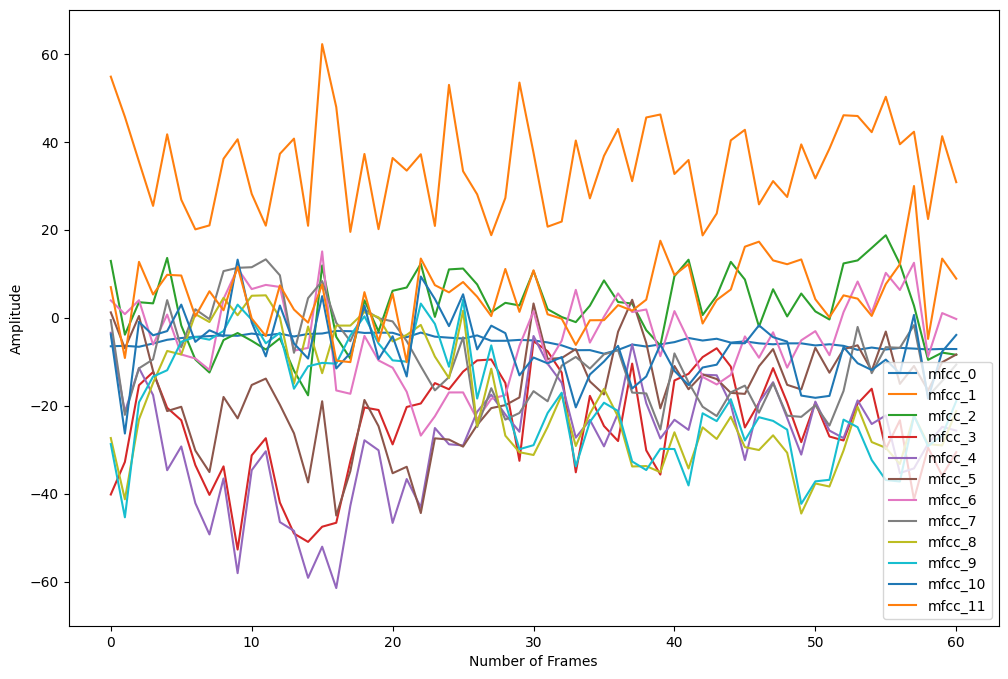

In [ ]:
plt.figure(figsize=(12, 8))
for i in range(0, 12):
    plt.ylim(-70, 70)
    plt.plot(x, mfcc_computed_2[:, i], label="mfcc_{}".format(i))
plt.legend(loc="lower right")
plt.ylabel("Amplitude")
plt.xlabel("Number of Frames")

Text(0.5, 0, 'Number of Frames')

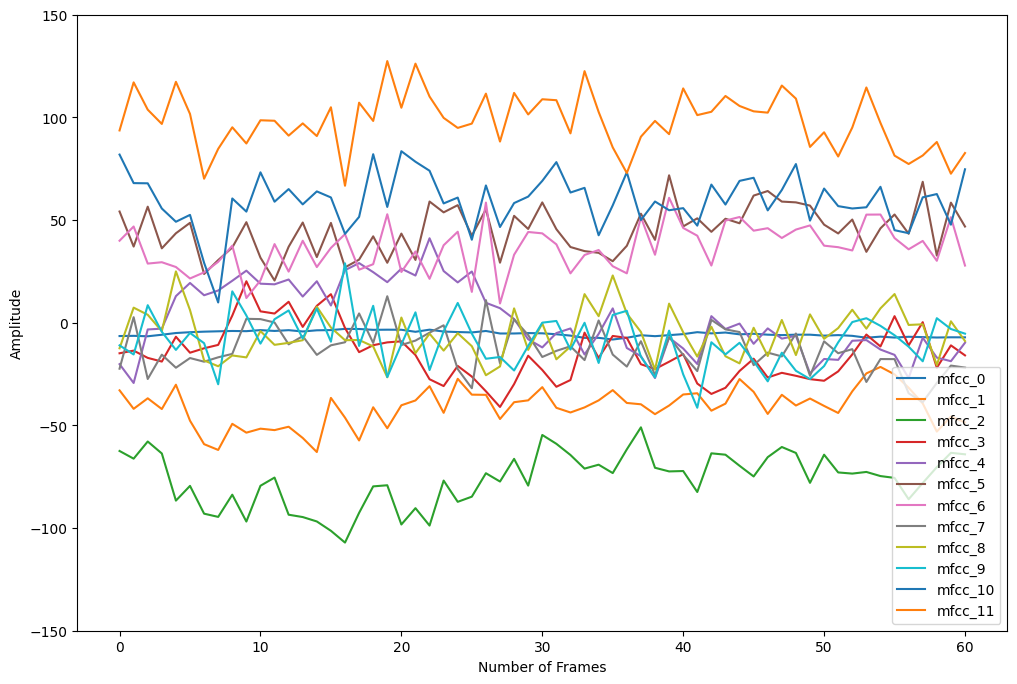

In [ ]:
plt.figure(figsize=(12, 8))

for i in range(0, 12):
    plt.ylim(-150, 150)
    plt.plot(x, mfcc_computed[:, i], label="mfcc_{}".format(i))
plt.legend(loc="lower right")
plt.ylabel("Amplitude")
plt.xlabel("Number of Frames")

Text(0.5, 0, 'Number of Frames')

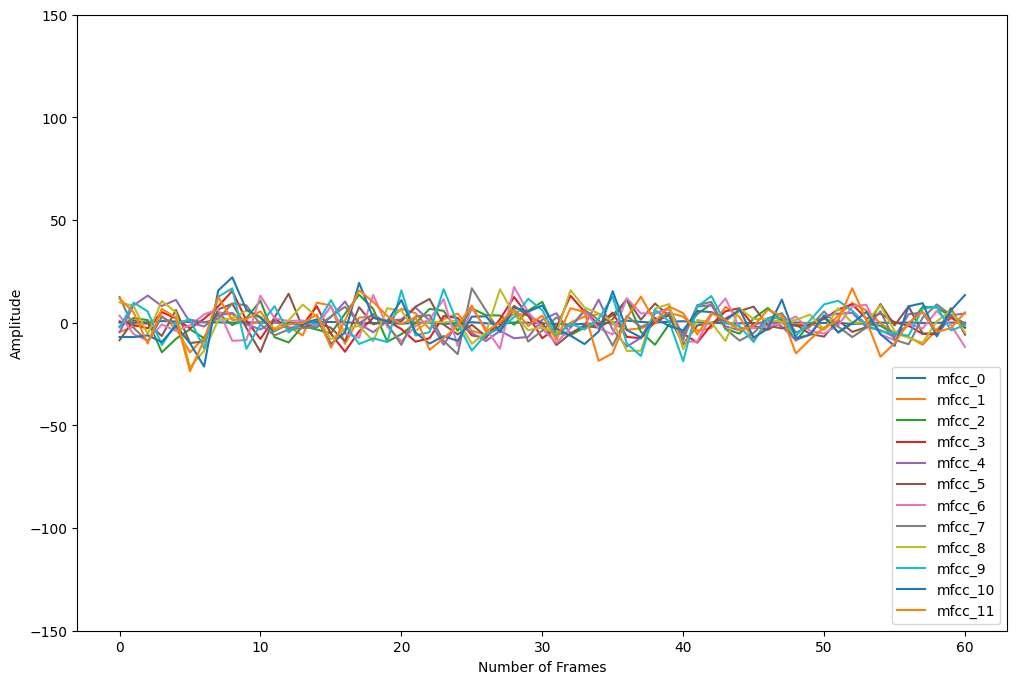

In [ ]:
plt.figure(figsize=(12, 8))
for i in range(0, 12):
    plt.ylim(-150, 150)
    plt.plot(x, first_delta_mfcc_computed[:, i], label="mfcc_{}".format(i))
plt.legend(loc="lower right")
plt.ylabel("Amplitude")
plt.xlabel("Number of Frames")

Text(0.5, 0, 'Number of Frames')

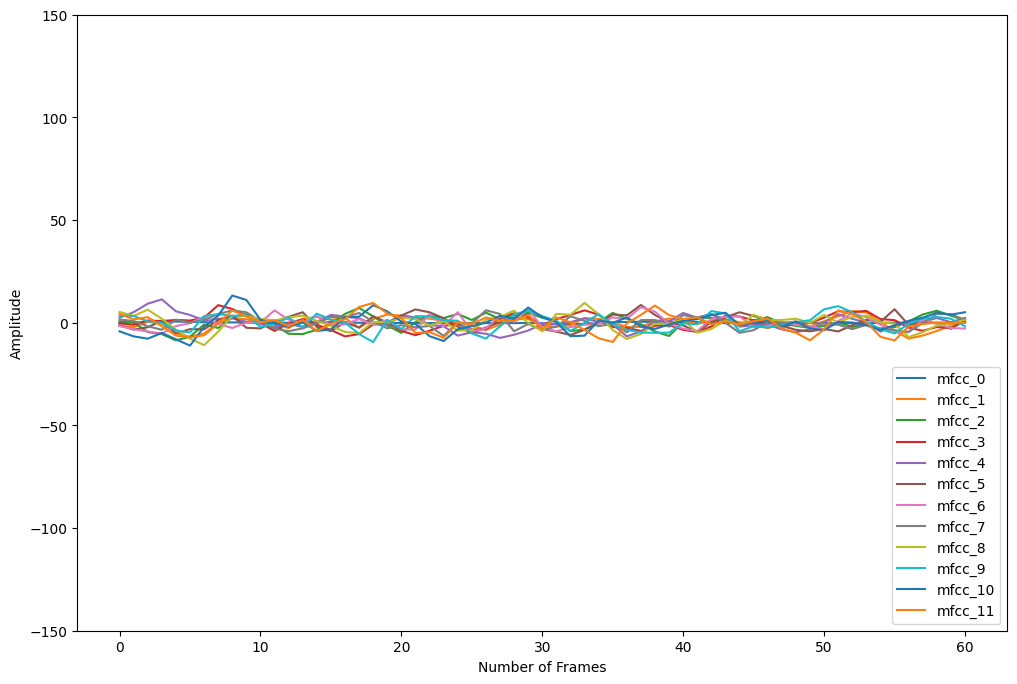

In [ ]:
plt.figure(figsize=(12, 8))
for i in range(0, 12):
    plt.ylim(-150, 150)
    plt.plot(x, second_delta_mfcc_computed[:, i], label="mfcc_{}".format(i))
plt.legend(loc="lower right")
plt.ylabel("Amplitude")
plt.xlabel("Number of Frames")

Text(0.5, 0, 'Number of Frames')

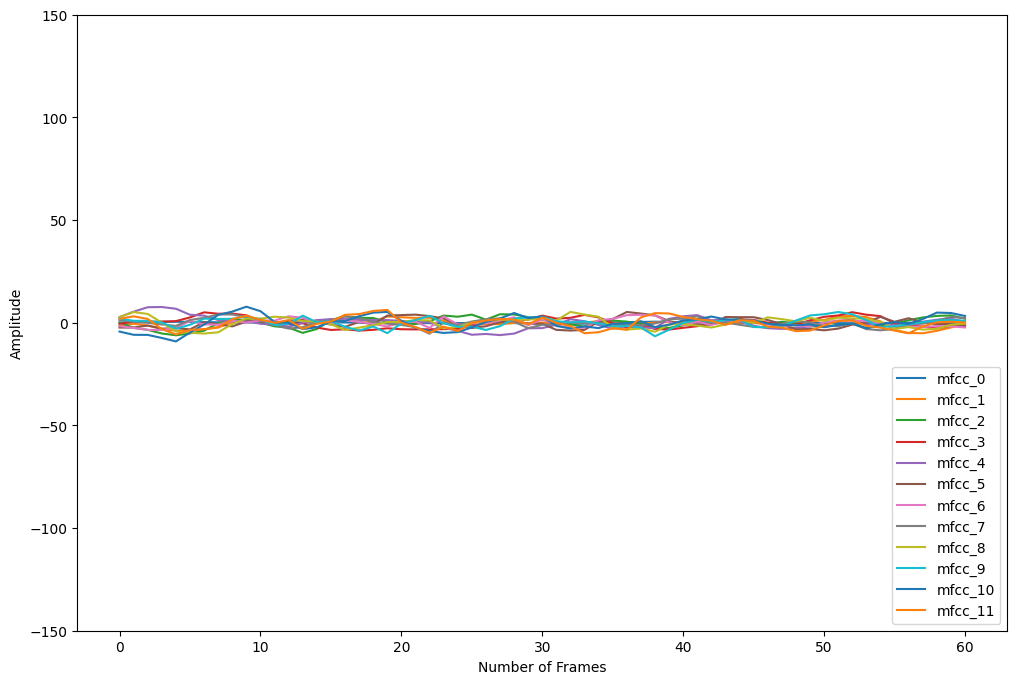

In [ ]:
plt.figure(figsize=(12, 8))
for i in range(0, 12):
    plt.ylim(-150, 150)
    plt.plot(x, third_delta_mfcc_computed[:, i], label="mfcc_{}".format(i))
plt.legend(loc="lower right")
plt.ylabel("Amplitude")
plt.xlabel("Number of Frames")

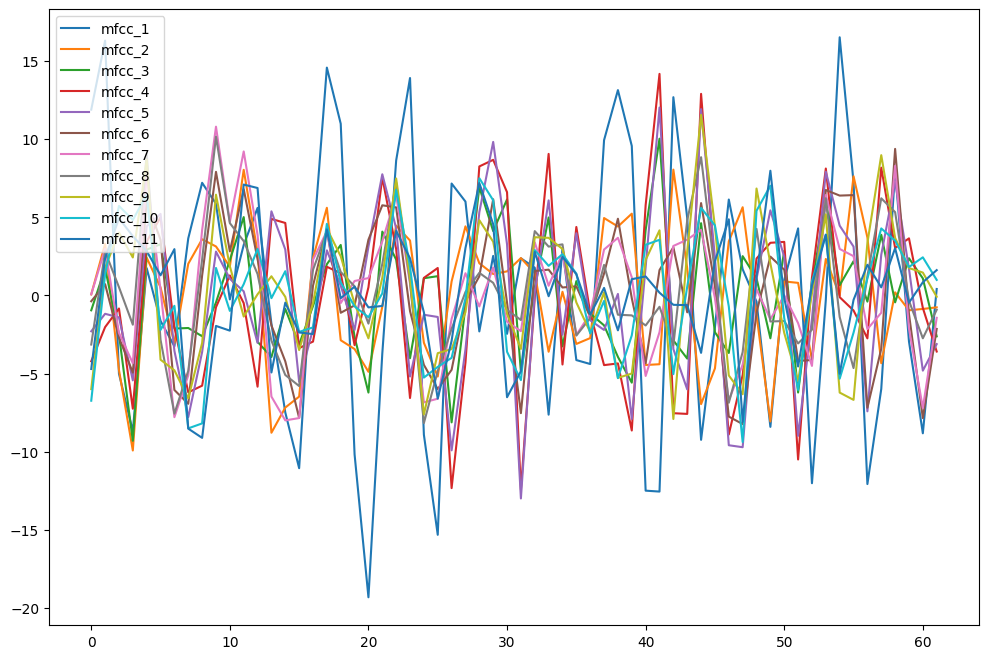

In [ ]:
plt.figure(figsize=(12, 8))
for i in range(1, 12):
    plt.plot(x, first_delta_mfcc_computed_2[:, i], label="mfcc_{}".format(i))
plt.legend(loc="upper left")

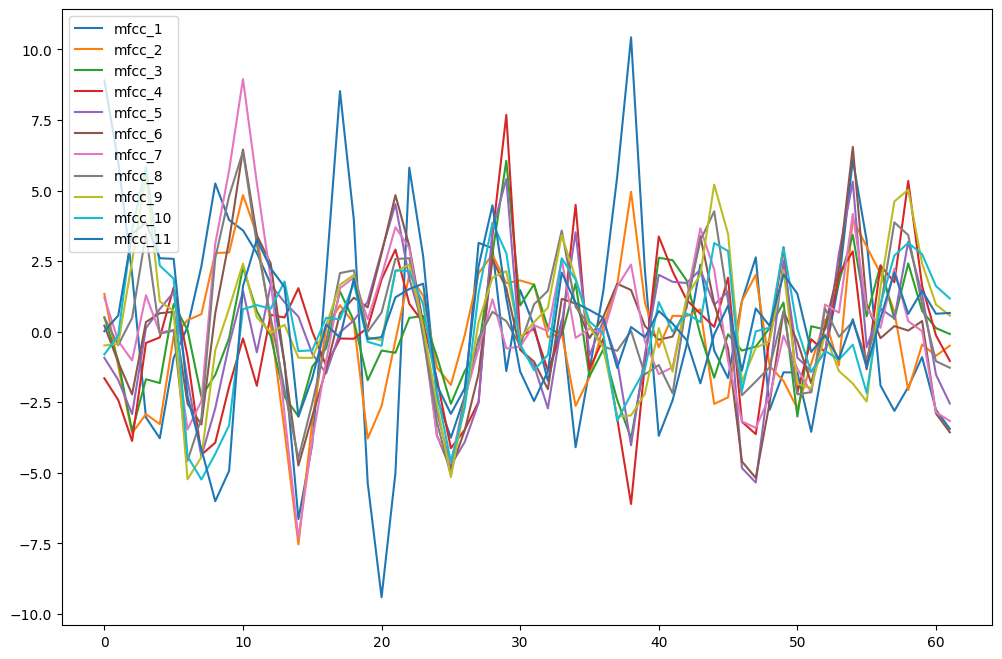

In [ ]:
plt.figure(figsize=(12, 8))
for i in range(1, 12):
    plt.plot(x, second_delta_mfcc_computed_2[:, i], label="mfcc_{}".format(i))
plt.legend(loc="upper left")

In [ ]:
plot_roc_curve untuk memplot ROC

In [ ]:
def plot_roc_curve(fpr, tpr, auc):
    plt.plot(fpr, tpr, color="orange", label="ROC")
    #     plt.plot([0, 1], [0, 1], color="darkblue", linestyle="--")
    plt.fill_between(fpr, tpr, color="blue", alpha=0.3)
    plt.text(0.5, 0.5, "AUC = {}".format(auc), fontsize=9)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend()
    plt.show()

In [ ]:
get_processed dan train_pipeline berfungsi untuk mentrain data

In [ ]:
def get_processed(
    is_hrmfcc=True,
    lower_superset=0,
    upper_superset=2500,
    lower_roi=2000,
    upper_roi=2500,
    factor_b=1,
    delta_order=1,
    concat_func=concat_feature,
    append_delta=True,
):
    dict_feat_arteri, labels_arteri, placements_arteri = concat_func(
        "sample_arteri",
        is_hrmfcc,
        lower_superset,
        upper_superset,
        lower_roi,
        upper_roi,
        factor_b,
        delta_order,
        append_delta,
    )
    dict_feat_probe, labels_probe, placements_probe = concat_func(
        "sample_probe",
        is_hrmfcc,
        lower_superset,
        upper_superset,
        lower_roi,
        upper_roi,
        factor_b,
        delta_order,
        append_delta,
    )
    dict_feat_vena, labels_vena, placements_vena = concat_func(
        "sample_vena",
        is_hrmfcc,
        lower_superset,
        upper_superset,
        lower_roi,
        upper_roi,
        factor_b,
        delta_order,
        append_delta,
    )

    df_arteri = pd.DataFrame(dict_feat_arteri)
    df_arteri["labels"] = labels_arteri
    df_arteri["placements"] = placements_arteri

    df_probe = pd.DataFrame(dict_feat_probe)
    df_probe["labels"] = labels_probe
    df_probe["placements"] = placements_probe

    df_vena = pd.DataFrame(dict_feat_vena)
    df_vena["labels"] = labels_vena
    df_vena["placements"] = placements_vena

    df = (
        df_arteri.append(df_probe)
        .reset_index(drop=True)
        .append(df_vena)
        .reset_index(drop=True)
    )
    df["two_class_labels"] = np.where(
        (df["labels"] != "sample_arteri"), "sample_non_arteri", df["labels"]
    )

    return df

In [ ]:
def train_pipeline(
    df,
    is_genetic=True,
    is_ensemble=True,
    is_cross_val=True,
    is_dnn=False,
    n_cv=5,
    random_split=False,
    test_split_ratio=0.3,
):
    df1 = df.copy()
    display(df1.head())
    maper = {"sample_arteri": 1, "sample_non_arteri": 0}
    df1["two_class_labels"] = df1["two_class_labels"].map(maper)
    ys = df1["two_class_labels"]
    xs = df1.drop(columns=["labels", "two_class_labels", "placements"])

    if not is_dnn:
        mdl_class = SVC(gamma="auto", kernel="rbf", random_state=42)
        model = make_pipeline(StandardScaler(), mdl_class)
        if is_ensemble:
            from sklearn.ensemble import BaggingClassifier

            model = make_pipeline(
                StandardScaler(), BaggingClassifier(mdl_class, random_state=42)
            )

    else:
        from sklearn.neural_network import MLPClassifier

        mdl_class = MLPClassifier(random_state=42)
        model = make_pipeline(StandardScaler(), mdl_class)

    if is_genetic:
        model = GeneticSelectionCV(
            model, cv=3, scoring="accuracy", max_features=5, n_population=100, n_jobs=-1
        )

    if is_cross_val:
        print("-" * 50, "Run CV", "-" * 50)

        scoring = {
            "acc": "accuracy",
            "prec_weighted": "precision_weighted",
            "rec_weighted": "recall_weighted",
            "f1_score_weighted": "f1_weighted",
            "roc_auc_score": "roc_auc",
        }
        acc_scores = cross_validate(model, xs, ys, scoring=scoring, cv=n_cv)

        #         acc_scores = cross_val_score(model, xs, ys, cv=n_cv, n_jobs=-1, scoring=scoring)
        #         print(
        #             "%0.2f median accuracy, %0.2f mean accuracy with a standard deviation of %0.2f"
        #             % (np.median(acc_scores), acc_scores.mean(), acc_scores.std())
        #         )

        #         print("-"*50, 'Run CV', '-'*50)
        #         f1_scores = cross_val_score(model, xs, ys, cv=5, scoring="f1", n_jobs=-1)
        #         print(
        #             "%0.2f median f1, %0.2f mean f1 with a standard deviation of %0.2f"
        #             % (np.median(f1_scores), f1_scores.mean(), f1_scores.std())
        #         )

        #         precision_scores = cross_val_score(
        #             model, xs, ys, cv=5, scoring="precision", n_jobs=-1
        #         )
        #         print(
        #             "%0.2f median precision, %0.2f mean precision with a standard deviation of %0.2f"
        #             % (
        #                 np.median(precision_scores),
        #                 precision_scores.mean(),
        #                 precision_scores.std(),
        #             )
        #         )

        #         recall_scores = cross_val_score(
        #             model, xs, ys, cv=5, scoring="recall", n_jobs=-1
        #         )
        #         print(
        #             "%0.2f median recall, %0.2f mean recall with a standard deviation of %0.2f"
        #             % (np.median(recall_scores), recall_scores.mean(), recall_scores.std())
        #         )

        #         cross_val_results = {
        #             "acc_mean": acc_scores.mean(),
        #             "acc_median": np.median(acc_scores),
        #             "acc_std": acc_scores.std(),
        #             "f1_mean": f1_scores.mean(),
        #             "f1_median": np.median(f1_scores),
        #             "f1_std": f1_scores.std(),
        #             "precision_mean": precision_scores.mean(),
        #             "precision_median": np.median(precision_scores),
        #             "precision_std": precision_scores.std(),
        #             "recall_mean": recall_scores.mean(),
        #             "recall_median": np.median(recall_scores),
        #             "recall_std": recall_scores.std(),
        #         }

        return model, acc_scores
    if not random_split:
        train = df1[df1.placements == "radial"].reset_index(drop=True)
        y_train = train["two_class_labels"]
        X_train = train.drop(columns=["labels", "two_class_labels", "placements"])

        test = df1[df1.placements == "wasir"].reset_index(drop=True)
        y_test = test["two_class_labels"]
        X_test = test.drop(columns=["labels", "two_class_labels", "placements"])

        model = model.fit(X_train, y_train)
        y_preds = model.predict(X_test)

        report = classification_report(y_test, y_preds, output_dict=True)
        report_df = pd.DataFrame(report).transpose()
        return model, report_df

    #     if is_cv:

    #         results = cross_validate(estimator=model,
    #                                X=_X,
    #                                y=_y,
    #                                cv=_cv,
    #                                scoring=_scoring,
    #                                return_train_score=True)

    print("RUN THIS")

    y = df1["two_class_labels"]
    X = df1.drop(columns=["labels", "two_class_labels", "placements"])

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_split_ratio, random_state=42
    )

    print(model)
    model = model.fit(X_train, y_train)
    y_preds = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    report = classification_report(y_test, y_preds, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    return model, report_df, y_pred_proba, y_test

Dibawah berfungsi untuk mendapatkan datanya

In [ ]:
df_b_1 = get_processed(
    is_hrmfcc=True,
    lower_superset=0,
    upper_superset=2800,
    lower_roi=2000,
    upper_roi=2500,
    factor_b=1,
    delta_order=0,
)

df_no_mfcc = get_processed(
    is_hrmfcc=False,
    lower_superset=0,
    upper_superset=2800,
    lower_roi=2000,
    upper_roi=2500,
    factor_b=4,
    delta_order=0,
)

df_mfcc_d_1 = get_processed(
    is_hrmfcc=True,
    lower_superset=0,
    upper_superset=2800,
    lower_roi=2000,
    upper_roi=2500,
    factor_b=1,
    delta_order=1,
    concat_func=concat_feature_delta,
    append_delta=False,
)

df_mfcc_d_2 = get_processed(
    is_hrmfcc=True,
    lower_superset=0,
    upper_superset=2800,
    lower_roi=2000,
    upper_roi=2500,
    factor_b=1,
    delta_order=2,
    concat_func=concat_feature_delta,
    append_delta=False,
)

df_mfcc_d_3 = get_processed(
    is_hrmfcc=True,
    lower_superset=0,
    upper_superset=2800,
    lower_roi=2000,
    upper_roi=2500,
    factor_b=1,
    delta_order=3,
    concat_func=concat_feature_delta,
    append_delta=False,
)


df_mfcc_d_3_append = get_processed(
    is_hrmfcc=True,
    lower_superset=0,
    upper_superset=2800,
    lower_roi=2000,
    upper_roi=2500,
    factor_b=1,
    delta_order=3,
    concat_func=concat_feature_delta,
    append_delta=True,
)

Proses train dengan DNN

In [ ]:
mdl1, results1, y_pred_proba, y_test = train_pipeline(
    df_no_mfcc,
    is_genetic=False,
    is_dnn=True,
    is_cross_val=False,
    random_split=True,
    test_split_ratio=0.2,
)


fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba[:, 1])
print(metrics.roc_auc_score(y_test, y_pred_proba[:, 1]))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, metrics.roc_auc_score(y_test, y_pred_proba[:, 1]))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_proba[:, 1] > 0.5).ravel()
print(tn, fp, fn, tp)


mdl2, results2, y_pred_proba, y_test = train_pipeline(
    df_b_1,
    is_genetic=False,
    is_dnn=True,
    is_cross_val=False,
    random_split=True,
    test_split_ratio=0.2,
)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba[:, 1])
print(metrics.roc_auc_score(y_test, y_pred_proba[:, 1]))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, metrics.roc_auc_score(y_test, y_pred_proba[:, 1]))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_proba[:, 1] > 0.5).ravel()
print(tn, fp, fn, tp)

mdl3, results3, y_pred_proba, y_test = train_pipeline(
    df_mfcc_d_1,
    is_genetic=False,
    is_dnn=True,
    is_cross_val=False,
    random_split=True,
    test_split_ratio=0.2,
)


fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba[:, 1])
print(metrics.roc_auc_score(y_test, y_pred_proba[:, 1]))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, metrics.roc_auc_score(y_test, y_pred_proba[:, 1]))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_proba[:, 1] > 0.5).ravel()
print(tn, fp, fn, tp)


mdl4, results4, y_pred_proba, y_test = train_pipeline(
    df_mfcc_d_2,
    is_genetic=False,
    is_dnn=True,
    is_cross_val=False,
    random_split=True,
    test_split_ratio=0.2,
)


fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba[:, 1])
print(metrics.roc_auc_score(y_test, y_pred_proba[:, 1]))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, metrics.roc_auc_score(y_test, y_pred_proba[:, 1]))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_proba[:, 1] > 0.5).ravel()
print(tn, fp, fn, tp)

mdl5, results5, y_pred_proba, y_test = train_pipeline(
    df_mfcc_d_3,
    is_genetic=False,
    is_dnn=True,
    is_cross_val=False,
    random_split=True,
    test_split_ratio=0.2,
)


fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba[:, 1])
print(metrics.roc_auc_score(y_test, y_pred_proba[:, 1]))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, metrics.roc_auc_score(y_test, y_pred_proba[:, 1]))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_proba[:, 1] > 0.5).ravel()
print(tn, fp, fn, tp)

mdl6, results6, y_pred_proba, y_test = train_pipeline(
    df_mfcc_d_3_append,
    is_genetic=False,
    is_dnn=True,
    is_cross_val=False,
    random_split=True,
    test_split_ratio=0.2,
)

Proses train dengan SVM

In [ ]:
mdl1, results1, y_pred_proba_1, y_test_1 = train_pipeline(
    df_no_mfcc,
    is_genetic=True,
    is_dnn=False,
    is_cross_val=False,
    random_split=True,
    test_split_ratio=0.2,
)

mdl2, results2, y_pred_proba_2, y_test_2 = train_pipeline(
    df_b_1,
    is_genetic=True,
    is_dnn=False,
    is_cross_val=False,
    random_split=True,
    test_split_ratio=0.2,
)

mdl3, results3, y_pred_proba_3, y_test_3 = train_pipeline(
    df_mfcc_d_1,
    is_genetic=True,
    is_dnn=False,
    is_cross_val=False,
    random_split=True,
    test_split_ratio=0.2,
)

mdl4, results4, y_pred_proba_4, y_test_4 = train_pipeline(
    df_mfcc_d_2,
    is_genetic=True,
    is_dnn=False,
    is_cross_val=False,
    random_split=True,
    test_split_ratio=0.2,
)


mdl5, results5, y_pred_proba_5, y_test_5 = train_pipeline(
    df_mfcc_d_3,
    is_genetic=True,
    is_dnn=False,
    is_cross_val=False,
    random_split=True,
    test_split_ratio=0.2,
)


mdl6, results6, y_pred_proba_6, y_test_6 = train_pipeline(
    df_mfcc_d_3_append,
    is_genetic=True,
    is_dnn=False,
    is_cross_val=False,
    random_split=True,
    test_split_ratio=0.2,
)

In [ ]:
mdl6, results6, y_pred_proba_6, y_test_6 = train_pipeline(
    df_mfcc_d_3_append,
    is_genetic=True,
    is_dnn=False,
    is_cross_val=False,
    random_split=True,
    test_split_ratio=0.2,
)

,mfcc_mean_0,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,...,mfcc_delta_3_90_percentile_5,mfcc_delta_3_90_percentile_6,mfcc_delta_3_90_percentile_7,mfcc_delta_3_90_percentile_8,mfcc_delta_3_90_percentile_9,mfcc_delta_3_90_percentile_10,mfcc_delta_3_90_percentile_11,labels,placements,two_class_labels
0,-7.052863,2.636221,-17.532285,-0.580164,-18.528713,12.261655,0.633621,-0.242760,11.021576,-12.450270,...,2.398310,2.435196,2.653608,2.178820,2.182496,2.695588,2.593177,sample_arteri,wasir,sample_arteri
1,-6.650912,3.620567,-19.078369,-3.216438,-22.506949,16.059184,3.654717,-1.155334,8.040081,-14.527742,...,2.511174,1.936291,1.794141,1.696560,1.866796,1.681434,1.591425,sample_arteri,wasir,sample_arteri
2,-4.078309,-6.931975,-8.672954,-13.645109,-9.970790,5.381896,11.133583,2.538870,5.858169,-8.189650,...,1.663902,2.229879,1.199221,1.544127,1.346920,1.882218,1.621732,sample_arteri,wasir,sample_arteri
3,-5.370570,2.518105,-22.889475,-2.138711,-18.527682,10.085308,3.514473,1.190402,9.388637,-12.171850,...,2.078236,2.268601,1.327310,1.856112,2.138849,2.433772,1.405552,sample_arteri,radial,sample_arteri
4,-5.831666,2.637562,-19.270747,-2.122720,-18.003656,7.701848,0.906653,-1.728543,6.848323,-10.278918,...,1.809377,2.554876,2.442556,1.873905,1.844849,2.160930,1.494673,sample_arteri,radial,sample_arteri


RUN THIS
GeneticSelectionCV(cv=3,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('baggingclassifier',
                                              BaggingClassifier(estimator=SVC(gamma='auto',
                                                                              random_state=42),
                                                                random_state=42))]),
                   max_features=5, n_jobs=-1, n_population=100,
                   scoring='accuracy')


In [ ]:
mdl2.support_

array([False, False,  True, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False])

In [ ]:
mdl2.support_.shape

(60,)

In [ ]:
mdl3.support_

array([False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
mdl4.support_

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
mdl5.support_

array([False,  True, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
mdl6.support_

array([False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [ ]:
results6

,precision,recall,f1-score,support
0,0.900000,1.000000,0.947368,27.000000
1,1.000000,0.875000,0.933333,24.000000
accuracy,0.941176,0.941176,0.941176,0.941176
macro avg,0.950000,0.937500,0.940351,51.000000
weighted avg,0.947059,0.941176,0.940764,51.000000


In [ ]:
results5

,precision,recall,f1-score,support
0,0.870968,1.000000,0.931034,27.000000
1,1.000000,0.833333,0.909091,24.000000
accuracy,0.921569,0.921569,0.921569,0.921569
macro avg,0.935484,0.916667,0.920063,51.000000
weighted avg,0.931689,0.921569,0.920708,51.000000


In [ ]:
results4

,precision,recall,f1-score,support
0,0.928571,0.962963,0.945455,27.000000
1,0.956522,0.916667,0.936170,24.000000
accuracy,0.941176,0.941176,0.941176,0.941176
macro avg,0.942547,0.939815,0.940812,51.000000
weighted avg,0.941725,0.941176,0.941085,51.000000


In [ ]:
results3

,precision,recall,f1-score,support
0,0.962963,0.962963,0.962963,27.000000
1,0.958333,0.958333,0.958333,24.000000
accuracy,0.960784,0.960784,0.960784,0.960784
macro avg,0.960648,0.960648,0.960648,51.000000
weighted avg,0.960784,0.960784,0.960784,51.000000


In [ ]:
results2

,precision,recall,f1-score,support
0,0.896552,0.962963,0.928571,27.000000
1,0.954545,0.875000,0.913043,24.000000
accuracy,0.921569,0.921569,0.921569,0.921569
macro avg,0.925549,0.918981,0.920807,51.000000
weighted avg,0.923843,0.921569,0.921264,51.000000


In [ ]:
mdl1.support_

array([False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
       False, False, False, False, False, False])

In [ ]:
support = [
    False,
    False,
    False,
    False,
    True,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    True,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    True,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    True,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
]

idx_lst = [idx for idx, x in enumerate(support) if x == True]

In [ ]:
from sklearn.ensemble import BaggingClassifier

mdl_class = SVC(gamma="auto", kernel="rbf", random_state=42)
model = make_pipeline(StandardScaler(), mdl_class)

model = make_pipeline(StandardScaler(), BaggingClassifier(mdl_class, random_state=42))

y = df_no_mfcc["two_class_labels"]
X = df_no_mfcc.drop(columns=["labels", "two_class_labels", "placements"])

X = X.iloc[:, idx_lst]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(model)
model = model.fit(X_train, y_train)
y_preds = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

report = classification_report(y_test, y_preds, output_dict=True)
report_df = pd.DataFrame(report).transpose()

y_pred_proba_1 = y_pred_proba
y_test_1 = y_test

In [ ]:
mdl1.support_

array([False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [ ]:
results2

,precision,recall,f1-score,support
0,0.896552,0.962963,0.928571,27.000000
1,0.954545,0.875000,0.913043,24.000000
accuracy,0.921569,0.921569,0.921569,0.921569
macro avg,0.925549,0.918981,0.920807,51.000000
weighted avg,0.923843,0.921569,0.921264,51.000000


In [ ]:
results1

,precision,recall,f1-score,support
0,0.931034,1.000000,0.964286,27.000000
1,1.000000,0.916667,0.956522,24.000000
accuracy,0.960784,0.960784,0.960784,0.960784
macro avg,0.965517,0.958333,0.960404,51.000000
weighted avg,0.963489,0.960784,0.960632,51.000000


In [ ]:
results1

,precision,recall,f1-score,support
0,0.900000,1.000000,0.947368,27.000000
1,1.000000,0.875000,0.933333,24.000000
accuracy,0.941176,0.941176,0.941176,0.941176
macro avg,0.950000,0.937500,0.940351,51.000000
weighted avg,0.947059,0.941176,0.940764,51.000000


In [ ]:
results2

,precision,recall,f1-score,support
0,1.000000,0.962963,0.981132,27.000000
1,0.960000,1.000000,0.979592,24.000000
accuracy,0.980392,0.980392,0.980392,0.980392
macro avg,0.980000,0.981481,0.980362,51.000000
weighted avg,0.981176,0.980392,0.980407,51.000000


In [ ]:
results3

,precision,recall,f1-score,support
0,1.000000,0.962963,0.981132,27.000000
1,0.960000,1.000000,0.979592,24.000000
accuracy,0.980392,0.980392,0.980392,0.980392
macro avg,0.980000,0.981481,0.980362,51.000000
weighted avg,0.981176,0.980392,0.980407,51.000000


In [ ]:
results4

,precision,recall,f1-score,support
0,0.962963,0.962963,0.962963,27.000000
1,0.958333,0.958333,0.958333,24.000000
accuracy,0.960784,0.960784,0.960784,0.960784
macro avg,0.960648,0.960648,0.960648,51.000000
weighted avg,0.960784,0.960784,0.960784,51.000000


In [ ]:
results5

,precision,recall,f1-score,support
0,0.900000,1.000000,0.947368,27.000000
1,1.000000,0.875000,0.933333,24.000000
accuracy,0.941176,0.941176,0.941176,0.941176
macro avg,0.950000,0.937500,0.940351,51.000000
weighted avg,0.947059,0.941176,0.940764,51.000000


In [ ]:
results6

,precision,recall,f1-score,support
0,0.962963,0.962963,0.962963,27.000000
1,0.958333,0.958333,0.958333,24.000000
accuracy,0.960784,0.960784,0.960784,0.960784
macro avg,0.960648,0.960648,0.960648,51.000000
weighted avg,0.960784,0.960784,0.960784,51.000000


In [ ]:
#SVM GA B=2

In [ ]:
mdl1, results1, y_pred_proba, y_test = train_pipeline(
    df_no_mfcc,
    is_genetic=False,
    is_dnn=False,
    is_cross_val=False,
    random_split=True,
    test_split_ratio=0.2,
)

mdl2, results2, y_pred_proba, y_test = train_pipeline(
    df_b_1,
    is_genetic=False,
    is_dnn=False,
    is_cross_val=False,
    random_split=True,
    test_split_ratio=0.2,
)

mdl3, results3, y_pred_proba, y_test = train_pipeline(
    df_mfcc_d_1,
    is_genetic=False,
    is_dnn=False,
    is_cross_val=False,
    random_split=True,
    test_split_ratio=0.2,
)

mdl4, results4, y_pred_proba, y_test = train_pipeline(
    df_mfcc_d_2,
    is_genetic=False,
    is_dnn=False,
    is_cross_val=False,
    random_split=True,
    test_split_ratio=0.2,
)


mdl5, results5, _, _ = train_pipeline(
    df_mfcc_d_3,
    is_genetic=False,
    is_dnn=False,
    is_cross_val=False,
    random_split=True,
    test_split_ratio=0.2,
)


mdl6, results6, _, _ = train_pipeline(
    df_mfcc_d_3_append,
    is_genetic=False,
    is_dnn=False,
    is_cross_val=False,
    random_split=True,
    test_split_ratio=0.2,
)

,mfcc_mean_0,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,...,mfcc_90_percentile_5,mfcc_90_percentile_6,mfcc_90_percentile_7,mfcc_90_percentile_8,mfcc_90_percentile_9,mfcc_90_percentile_10,mfcc_90_percentile_11,labels,placements,two_class_labels
0,-7.052863,25.442362,5.870423,-10.859158,-10.615965,-2.098477,4.526341,-1.064632,-9.466155,-11.990127,...,2.586591,11.126561,3.377197,-6.791607,-8.426636,-1.121668,6.234735,sample_arteri,wasir,sample_arteri
1,-6.650912,27.156367,6.639504,-11.679038,-11.942982,-3.326948,3.113516,-3.317941,-12.206822,-13.532318,...,2.226755,11.056811,3.047240,-7.715568,-7.811401,-1.381238,7.426494,sample_arteri,wasir,sample_arteri
2,-4.078309,17.574923,-12.095692,-4.074273,4.749446,-20.002012,11.339515,-8.214539,-19.716877,-0.023705,...,-9.081026,18.046046,-1.148669,-13.271442,5.171991,5.588222,-6.942203,sample_arteri,wasir,sample_arteri
3,-5.370570,27.647245,5.586904,-12.634577,-14.560454,-6.269393,1.251314,-2.590809,-9.996550,-11.732217,...,2.998206,8.777686,2.766315,-3.237508,-4.458918,-1.388904,5.686651,sample_arteri,radial,sample_arteri
4,-5.831666,24.386211,5.396429,-9.822789,-12.136999,-4.595045,2.263120,-0.773847,-7.695557,-10.162050,...,2.819384,8.540335,4.623022,-1.453323,-3.128530,0.138609,6.720013,sample_arteri,radial,sample_arteri


RUN THIS
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=SVC(gamma='auto',
                                                      random_state=42),
                                   random_state=42))])


,mfcc_mean_0,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,...,mfcc_90_percentile_5,mfcc_90_percentile_6,mfcc_90_percentile_7,mfcc_90_percentile_8,mfcc_90_percentile_9,mfcc_90_percentile_10,mfcc_90_percentile_11,labels,placements,two_class_labels
0,-7.052863,2.636221,-17.532285,-0.580164,-18.528713,12.261655,0.633621,-0.242760,11.021576,-12.450270,...,25.319051,10.081916,11.924820,19.495212,-3.363495,14.095529,0.198989,sample_arteri,wasir,sample_arteri
1,-6.650912,3.620567,-19.078369,-3.216438,-22.506949,16.059184,3.654717,-1.155334,8.040081,-14.527742,...,25.311994,12.311469,8.428470,16.305867,-6.772348,16.707169,-0.204485,sample_arteri,wasir,sample_arteri
2,-4.078309,-6.931975,-8.672954,-13.645109,-9.970790,5.381896,11.133583,2.538870,5.858169,-8.189650,...,14.374873,19.629157,9.429797,12.325098,-0.307872,6.067708,3.512072,sample_arteri,wasir,sample_arteri
3,-5.370570,2.518105,-22.889475,-2.138711,-18.527682,10.085308,3.514473,1.190402,9.388637,-12.171850,...,18.704415,14.599644,8.986395,16.997311,-4.089562,17.372722,2.161341,sample_arteri,radial,sample_arteri
4,-5.831666,2.637562,-19.270747,-2.122720,-18.003656,7.701848,0.906653,-1.728543,6.848323,-10.278918,...,17.198656,10.392824,8.409180,16.141006,-1.500872,19.003251,3.096255,sample_arteri,radial,sample_arteri


RUN THIS
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=SVC(gamma='auto',
                                                      random_state=42),
                                   random_state=42))])


,mfcc_mean_0,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,...,mfcc_delta_1_90_percentile_5,mfcc_delta_1_90_percentile_6,mfcc_delta_1_90_percentile_7,mfcc_delta_1_90_percentile_8,mfcc_delta_1_90_percentile_9,mfcc_delta_1_90_percentile_10,mfcc_delta_1_90_percentile_11,labels,placements,two_class_labels
0,-7.052863,2.636221,-17.532285,-0.580164,-18.528713,12.261655,0.633621,-0.242760,11.021576,-12.450270,...,5.371341,7.120336,6.604536,6.277992,6.350197,8.637505,9.035533,sample_arteri,wasir,sample_arteri
1,-6.650912,3.620567,-19.078369,-3.216438,-22.506949,16.059184,3.654717,-1.155334,8.040081,-14.527742,...,5.483965,6.713479,6.783084,7.487399,7.520074,7.731967,5.786548,sample_arteri,wasir,sample_arteri
2,-4.078309,-6.931975,-8.672954,-13.645109,-9.970790,5.381896,11.133583,2.538870,5.858169,-8.189650,...,6.223309,5.504604,4.476125,4.451237,4.450132,6.589743,6.933292,sample_arteri,wasir,sample_arteri
3,-5.370570,2.518105,-22.889475,-2.138711,-18.527682,10.085308,3.514473,1.190402,9.388637,-12.171850,...,5.172077,5.819398,4.607483,6.119950,6.601897,6.731700,6.007504,sample_arteri,radial,sample_arteri
4,-5.831666,2.637562,-19.270747,-2.122720,-18.003656,7.701848,0.906653,-1.728543,6.848323,-10.278918,...,6.800425,6.391519,6.401716,6.124857,6.132282,5.363694,5.822075,sample_arteri,radial,sample_arteri


RUN THIS
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=SVC(gamma='auto',
                                                      random_state=42),
                                   random_state=42))])


,mfcc_mean_0,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,...,mfcc_delta_2_90_percentile_5,mfcc_delta_2_90_percentile_6,mfcc_delta_2_90_percentile_7,mfcc_delta_2_90_percentile_8,mfcc_delta_2_90_percentile_9,mfcc_delta_2_90_percentile_10,mfcc_delta_2_90_percentile_11,labels,placements,two_class_labels
0,-7.052863,2.636221,-17.532285,-0.580164,-18.528713,12.261655,0.633621,-0.242760,11.021576,-12.450270,...,3.404894,3.255830,3.216422,2.889753,3.191000,3.838459,3.760487,sample_arteri,wasir,sample_arteri
1,-6.650912,3.620567,-19.078369,-3.216438,-22.506949,16.059184,3.654717,-1.155334,8.040081,-14.527742,...,3.361975,2.459599,2.904056,2.687984,2.687681,3.241271,2.791491,sample_arteri,wasir,sample_arteri
2,-4.078309,-6.931975,-8.672954,-13.645109,-9.970790,5.381896,11.133583,2.538870,5.858169,-8.189650,...,2.877291,3.412859,2.181567,2.771287,2.198455,3.527126,2.502278,sample_arteri,wasir,sample_arteri
3,-5.370570,2.518105,-22.889475,-2.138711,-18.527682,10.085308,3.514473,1.190402,9.388637,-12.171850,...,3.244972,2.972735,1.794907,2.514137,2.836419,2.952132,3.117663,sample_arteri,radial,sample_arteri
4,-5.831666,2.637562,-19.270747,-2.122720,-18.003656,7.701848,0.906653,-1.728543,6.848323,-10.278918,...,3.157506,3.097550,3.717406,2.792084,2.628600,3.038884,2.866342,sample_arteri,radial,sample_arteri


RUN THIS
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=SVC(gamma='auto',
                                                      random_state=42),
                                   random_state=42))])


,mfcc_mean_0,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,...,mfcc_delta_3_90_percentile_5,mfcc_delta_3_90_percentile_6,mfcc_delta_3_90_percentile_7,mfcc_delta_3_90_percentile_8,mfcc_delta_3_90_percentile_9,mfcc_delta_3_90_percentile_10,mfcc_delta_3_90_percentile_11,labels,placements,two_class_labels
0,-7.052863,2.636221,-17.532285,-0.580164,-18.528713,12.261655,0.633621,-0.242760,11.021576,-12.450270,...,2.398310,2.435196,2.653608,2.178820,2.182496,2.695588,2.593177,sample_arteri,wasir,sample_arteri
1,-6.650912,3.620567,-19.078369,-3.216438,-22.506949,16.059184,3.654717,-1.155334,8.040081,-14.527742,...,2.511174,1.936291,1.794141,1.696560,1.866796,1.681434,1.591425,sample_arteri,wasir,sample_arteri
2,-4.078309,-6.931975,-8.672954,-13.645109,-9.970790,5.381896,11.133583,2.538870,5.858169,-8.189650,...,1.663902,2.229879,1.199221,1.544127,1.346920,1.882218,1.621732,sample_arteri,wasir,sample_arteri
3,-5.370570,2.518105,-22.889475,-2.138711,-18.527682,10.085308,3.514473,1.190402,9.388637,-12.171850,...,2.078236,2.268601,1.327310,1.856112,2.138849,2.433772,1.405552,sample_arteri,radial,sample_arteri
4,-5.831666,2.637562,-19.270747,-2.122720,-18.003656,7.701848,0.906653,-1.728543,6.848323,-10.278918,...,1.809377,2.554876,2.442556,1.873905,1.844849,2.160930,1.494673,sample_arteri,radial,sample_arteri


RUN THIS
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=SVC(gamma='auto',
                                                      random_state=42),
                                   random_state=42))])


,mfcc_mean_0,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,...,mfcc_delta_3_90_percentile_5,mfcc_delta_3_90_percentile_6,mfcc_delta_3_90_percentile_7,mfcc_delta_3_90_percentile_8,mfcc_delta_3_90_percentile_9,mfcc_delta_3_90_percentile_10,mfcc_delta_3_90_percentile_11,labels,placements,two_class_labels
0,-7.052863,2.636221,-17.532285,-0.580164,-18.528713,12.261655,0.633621,-0.242760,11.021576,-12.450270,...,2.398310,2.435196,2.653608,2.178820,2.182496,2.695588,2.593177,sample_arteri,wasir,sample_arteri
1,-6.650912,3.620567,-19.078369,-3.216438,-22.506949,16.059184,3.654717,-1.155334,8.040081,-14.527742,...,2.511174,1.936291,1.794141,1.696560,1.866796,1.681434,1.591425,sample_arteri,wasir,sample_arteri
2,-4.078309,-6.931975,-8.672954,-13.645109,-9.970790,5.381896,11.133583,2.538870,5.858169,-8.189650,...,1.663902,2.229879,1.199221,1.544127,1.346920,1.882218,1.621732,sample_arteri,wasir,sample_arteri
3,-5.370570,2.518105,-22.889475,-2.138711,-18.527682,10.085308,3.514473,1.190402,9.388637,-12.171850,...,2.078236,2.268601,1.327310,1.856112,2.138849,2.433772,1.405552,sample_arteri,radial,sample_arteri
4,-5.831666,2.637562,-19.270747,-2.122720,-18.003656,7.701848,0.906653,-1.728543,6.848323,-10.278918,...,1.809377,2.554876,2.442556,1.873905,1.844849,2.160930,1.494673,sample_arteri,radial,sample_arteri


RUN THIS
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=SVC(gamma='auto',
                                                      random_state=42),
                                   random_state=42))])


In [ ]:
results1

,precision,recall,f1-score,support
0,1.0,1.0,1.0,27.0
1,1.0,1.0,1.0,24.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,51.0
weighted avg,1.0,1.0,1.0,51.0


In [ ]:
results2

,precision,recall,f1-score,support
0,1.0,1.0,1.0,27.0
1,1.0,1.0,1.0,24.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,51.0
weighted avg,1.0,1.0,1.0,51.0


In [ ]:
results3

,precision,recall,f1-score,support
0,0.870968,1.000000,0.931034,27.000000
1,1.000000,0.833333,0.909091,24.000000
accuracy,0.921569,0.921569,0.921569,0.921569
macro avg,0.935484,0.916667,0.920063,51.000000
weighted avg,0.931689,0.921569,0.920708,51.000000


In [ ]:
results4

,precision,recall,f1-score,support
0,0.928571,0.962963,0.945455,27.000000
1,0.956522,0.916667,0.936170,24.000000
accuracy,0.941176,0.941176,0.941176,0.941176
macro avg,0.942547,0.939815,0.940812,51.000000
weighted avg,0.941725,0.941176,0.941085,51.000000


In [ ]:
results5

,precision,recall,f1-score,support
0,0.931034,1.000000,0.964286,27.000000
1,1.000000,0.916667,0.956522,24.000000
accuracy,0.960784,0.960784,0.960784,0.960784
macro avg,0.965517,0.958333,0.960404,51.000000
weighted avg,0.963489,0.960784,0.960632,51.000000


In [ ]:
results6

,precision,recall,f1-score,support
0,0.900000,1.000000,0.947368,27.000000
1,1.000000,0.875000,0.933333,24.000000
accuracy,0.941176,0.941176,0.941176,0.941176
macro avg,0.950000,0.937500,0.940351,51.000000
weighted avg,0.947059,0.941176,0.940764,51.000000


,mfcc_mean_0,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,...,mfcc_delta_1_90_percentile_5,mfcc_delta_1_90_percentile_6,mfcc_delta_1_90_percentile_7,mfcc_delta_1_90_percentile_8,mfcc_delta_1_90_percentile_9,mfcc_delta_1_90_percentile_10,mfcc_delta_1_90_percentile_11,labels,placements,two_class_labels
0,-7.052863,2.636221,-17.532285,-0.580164,-18.528713,12.261655,0.633621,-0.242760,11.021576,-12.450270,...,5.371341,7.120336,6.604536,6.277992,6.350197,8.637505,9.035533,sample_arteri,wasir,sample_arteri
1,-6.650912,3.620567,-19.078369,-3.216438,-22.506949,16.059184,3.654717,-1.155334,8.040081,-14.527742,...,5.483965,6.713479,6.783084,7.487399,7.520074,7.731967,5.786548,sample_arteri,wasir,sample_arteri
2,-4.078309,-6.931975,-8.672954,-13.645109,-9.970790,5.381896,11.133583,2.538870,5.858169,-8.189650,...,6.223309,5.504604,4.476125,4.451237,4.450132,6.589743,6.933292,sample_arteri,wasir,sample_arteri
3,-5.370570,2.518105,-22.889475,-2.138711,-18.527682,10.085308,3.514473,1.190402,9.388637,-12.171850,...,5.172077,5.819398,4.607483,6.119950,6.601897,6.731700,6.007504,sample_arteri,radial,sample_arteri
4,-5.831666,2.637562,-19.270747,-2.122720,-18.003656,7.701848,0.906653,-1.728543,6.848323,-10.278918,...,6.800425,6.391519,6.401716,6.124857,6.132282,5.363694,5.822075,sample_arteri,radial,sample_arteri


RUN THIS
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier', MLPClassifier(random_state=42))])
0.9876543209876544
Threshold value is: 0.2108700155770461


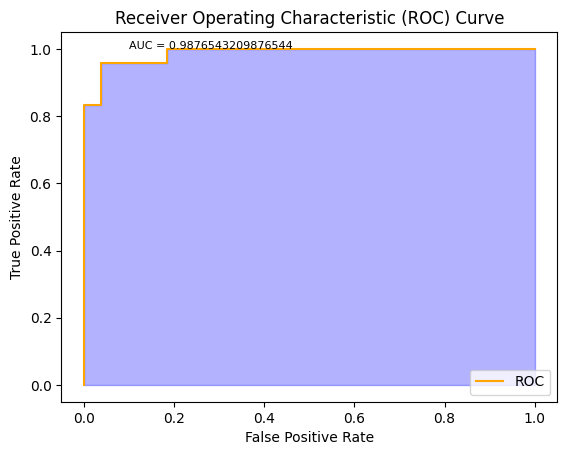

26 1 3 21
-------------------------------------------------- Next Run --------------------------------------------------


,mfcc_mean_0,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,...,mfcc_delta_2_90_percentile_5,mfcc_delta_2_90_percentile_6,mfcc_delta_2_90_percentile_7,mfcc_delta_2_90_percentile_8,mfcc_delta_2_90_percentile_9,mfcc_delta_2_90_percentile_10,mfcc_delta_2_90_percentile_11,labels,placements,two_class_labels
0,-7.052863,2.636221,-17.532285,-0.580164,-18.528713,12.261655,0.633621,-0.242760,11.021576,-12.450270,...,3.404894,3.255830,3.216422,2.889753,3.191000,3.838459,3.760487,sample_arteri,wasir,sample_arteri
1,-6.650912,3.620567,-19.078369,-3.216438,-22.506949,16.059184,3.654717,-1.155334,8.040081,-14.527742,...,3.361975,2.459599,2.904056,2.687984,2.687681,3.241271,2.791491,sample_arteri,wasir,sample_arteri
2,-4.078309,-6.931975,-8.672954,-13.645109,-9.970790,5.381896,11.133583,2.538870,5.858169,-8.189650,...,2.877291,3.412859,2.181567,2.771287,2.198455,3.527126,2.502278,sample_arteri,wasir,sample_arteri
3,-5.370570,2.518105,-22.889475,-2.138711,-18.527682,10.085308,3.514473,1.190402,9.388637,-12.171850,...,3.244972,2.972735,1.794907,2.514137,2.836419,2.952132,3.117663,sample_arteri,radial,sample_arteri
4,-5.831666,2.637562,-19.270747,-2.122720,-18.003656,7.701848,0.906653,-1.728543,6.848323,-10.278918,...,3.157506,3.097550,3.717406,2.792084,2.628600,3.038884,2.866342,sample_arteri,radial,sample_arteri


RUN THIS
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier', MLPClassifier(random_state=42))])
0.9922839506172839
Threshold value is: 0.258136595308473


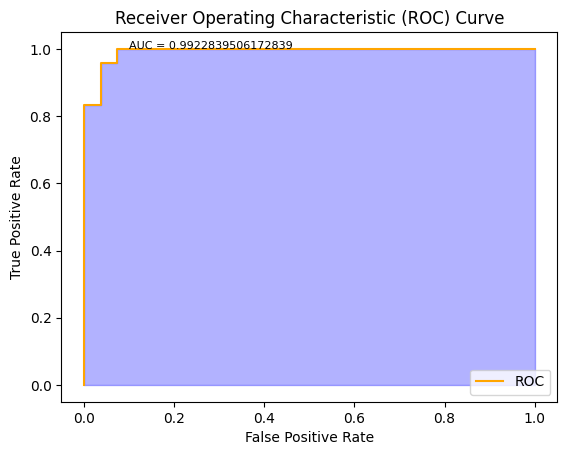

25 2 1 23
-------------------------------------------------- Next Run --------------------------------------------------


,mfcc_mean_0,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,...,mfcc_90_percentile_5,mfcc_90_percentile_6,mfcc_90_percentile_7,mfcc_90_percentile_8,mfcc_90_percentile_9,mfcc_90_percentile_10,mfcc_90_percentile_11,labels,placements,two_class_labels
0,-7.052863,32.447699,3.459494,-21.852628,-22.146351,-10.651340,-0.568581,-8.784036,-19.674163,-20.310824,...,-3.774921,10.409019,0.110017,-10.412898,-9.324481,4.163795,16.533423,sample_arteri,wasir,sample_arteri
1,-6.650912,34.586623,4.600301,-22.680491,-23.687531,-12.338713,-2.612704,-12.310372,-24.286862,-22.910527,...,-2.540516,10.775930,-3.072967,-16.173569,-13.908200,2.353175,19.245869,sample_arteri,wasir,sample_arteri
2,-4.078309,21.830961,-20.242804,-15.921626,4.164483,-34.152126,5.762690,-16.542512,-35.975956,-4.412883,...,-19.834427,15.369229,-2.532784,-21.610120,7.360083,17.583675,-11.124708,sample_arteri,wasir,sample_arteri
3,-5.370570,34.784187,2.334080,-24.863770,-28.151153,-16.845957,-4.677015,-9.522642,-18.784436,-19.036008,...,-5.730568,6.995247,4.448887,0.553173,-3.015035,2.775202,13.245820,sample_arteri,radial,sample_arteri
4,-5.831666,30.699395,2.229592,-20.775085,-24.618252,-14.544868,-4.428312,-9.175489,-18.012137,-19.014361,...,-3.134783,6.206308,4.437640,-0.830391,-3.058521,-0.696374,11.445413,sample_arteri,radial,sample_arteri


RUN THIS
GeneticSelectionCV(cv=3,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('baggingclassifier',
                                              BaggingClassifier(base_estimator=SVC(gamma='auto',
                                                                                   random_state=42)))]),
                   max_features=5, n_jobs=-1, n_population=100,
                   scoring='accuracy')
0.9976851851851851
Threshold value is: 1.0


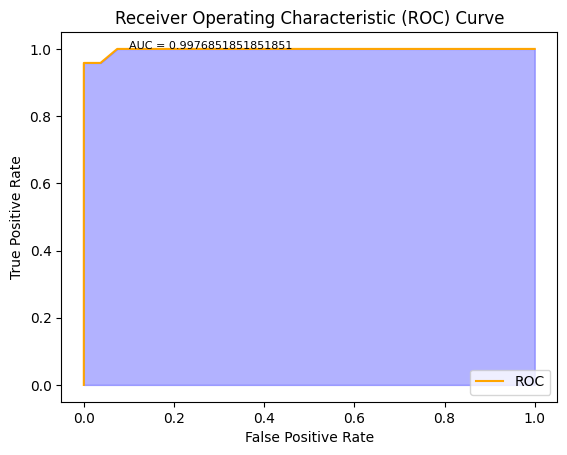

26 1 1 23
-------------------------------------------------- Next Run --------------------------------------------------


,mfcc_mean_0,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,...,mfcc_delta_1_90_percentile_5,mfcc_delta_1_90_percentile_6,mfcc_delta_1_90_percentile_7,mfcc_delta_1_90_percentile_8,mfcc_delta_1_90_percentile_9,mfcc_delta_1_90_percentile_10,mfcc_delta_1_90_percentile_11,labels,placements,two_class_labels
0,-7.052863,2.636221,-17.532285,-0.580164,-18.528713,12.261655,0.633621,-0.242760,11.021576,-12.450270,...,5.371341,7.120336,6.604536,6.277992,6.350197,8.637505,9.035533,sample_arteri,wasir,sample_arteri
1,-6.650912,3.620567,-19.078369,-3.216438,-22.506949,16.059184,3.654717,-1.155334,8.040081,-14.527742,...,5.483965,6.713479,6.783084,7.487399,7.520074,7.731967,5.786548,sample_arteri,wasir,sample_arteri
2,-4.078309,-6.931975,-8.672954,-13.645109,-9.970790,5.381896,11.133583,2.538870,5.858169,-8.189650,...,6.223309,5.504604,4.476125,4.451237,4.450132,6.589743,6.933292,sample_arteri,wasir,sample_arteri
3,-5.370570,2.518105,-22.889475,-2.138711,-18.527682,10.085308,3.514473,1.190402,9.388637,-12.171850,...,5.172077,5.819398,4.607483,6.119950,6.601897,6.731700,6.007504,sample_arteri,radial,sample_arteri
4,-5.831666,2.637562,-19.270747,-2.122720,-18.003656,7.701848,0.906653,-1.728543,6.848323,-10.278918,...,6.800425,6.391519,6.401716,6.124857,6.132282,5.363694,5.822075,sample_arteri,radial,sample_arteri


RUN THIS
GeneticSelectionCV(cv=3,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('baggingclassifier',
                                              BaggingClassifier(base_estimator=SVC(gamma='auto',
                                                                                   random_state=42)))]),
                   max_features=5, n_jobs=-1, n_population=100,
                   scoring='accuracy')
0.9567901234567902
Threshold value is: 0.4


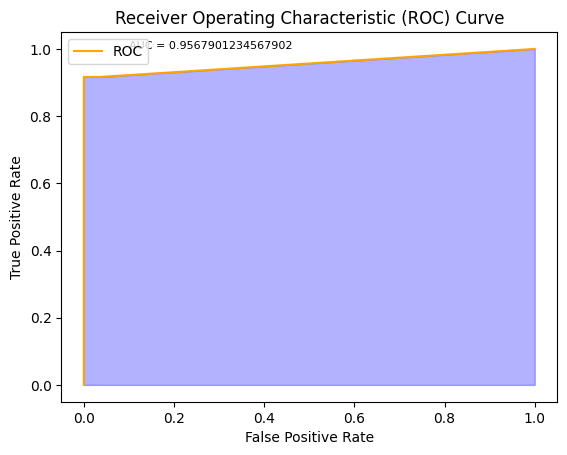

27 0 3 21
-------------------------------------------------- Next Run --------------------------------------------------


,mfcc_mean_0,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,...,mfcc_delta_2_90_percentile_5,mfcc_delta_2_90_percentile_6,mfcc_delta_2_90_percentile_7,mfcc_delta_2_90_percentile_8,mfcc_delta_2_90_percentile_9,mfcc_delta_2_90_percentile_10,mfcc_delta_2_90_percentile_11,labels,placements,two_class_labels
0,-7.052863,2.636221,-17.532285,-0.580164,-18.528713,12.261655,0.633621,-0.242760,11.021576,-12.450270,...,3.404894,3.255830,3.216422,2.889753,3.191000,3.838459,3.760487,sample_arteri,wasir,sample_arteri
1,-6.650912,3.620567,-19.078369,-3.216438,-22.506949,16.059184,3.654717,-1.155334,8.040081,-14.527742,...,3.361975,2.459599,2.904056,2.687984,2.687681,3.241271,2.791491,sample_arteri,wasir,sample_arteri
2,-4.078309,-6.931975,-8.672954,-13.645109,-9.970790,5.381896,11.133583,2.538870,5.858169,-8.189650,...,2.877291,3.412859,2.181567,2.771287,2.198455,3.527126,2.502278,sample_arteri,wasir,sample_arteri
3,-5.370570,2.518105,-22.889475,-2.138711,-18.527682,10.085308,3.514473,1.190402,9.388637,-12.171850,...,3.244972,2.972735,1.794907,2.514137,2.836419,2.952132,3.117663,sample_arteri,radial,sample_arteri
4,-5.831666,2.637562,-19.270747,-2.122720,-18.003656,7.701848,0.906653,-1.728543,6.848323,-10.278918,...,3.157506,3.097550,3.717406,2.792084,2.628600,3.038884,2.866342,sample_arteri,radial,sample_arteri


RUN THIS
GeneticSelectionCV(cv=3,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('baggingclassifier',
                                              BaggingClassifier(base_estimator=SVC(gamma='auto',
                                                                                   random_state=42)))]),
                   max_features=5, n_jobs=-1, n_population=100,
                   scoring='accuracy')
1.0
Threshold value is: 0.8


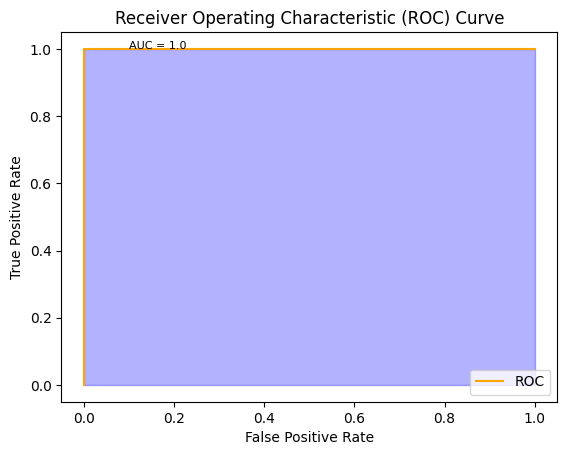

27 0 0 24
-------------------------------------------------- Next Run --------------------------------------------------


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# mdl1, results1, y_pred_proba, y_test = train_pipeline(
#     df_no_mfcc,
#     is_genetic=False,
#     is_dnn=True,
#     is_cross_val=False,
#     random_split=True,
#     test_split_ratio=0.2,
# )

# fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba[:, 1])
# print(metrics.roc_auc_score(y_test, y_pred_proba[:, 1]))
# optimal_idx = np.argmax(tpr - fpr)
# optimal_threshold = thresholds[optimal_idx]
# print("Threshold value is:", optimal_threshold)
# plot_roc_curve(fpr, tpr)

# print("-" * 50, "Next Run", "-" * 50)

# mdl2, results2, y_pred_proba, y_test = train_pipeline(
#     df_b_1,
#     is_genetic=False,
#     is_dnn=True,
#     is_cross_val=False,
#     random_split=True,
#     test_split_ratio=0.2,
# )

# fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba[:, 1])
# print(metrics.roc_auc_score(y_test, y_pred_proba[:, 1]))
# optimal_idx = np.argmax(tpr - fpr)
# optimal_threshold = thresholds[optimal_idx]
# print("Threshold value is:", optimal_threshold)
# plot_roc_curve(fpr, tpr)

# print("-" * 50, "Next Run", "-" * 50)

mdl3, results3, y_pred_proba, y_test = train_pipeline(
    df_mfcc_d_1,
    is_genetic=False,
    is_dnn=True,
    is_cross_val=False,
    random_split=True,
    test_split_ratio=0.2,
)


fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba[:, 1])
print(metrics.roc_auc_score(y_test, y_pred_proba[:, 1]))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, metrics.roc_auc_score(y_test, y_pred_proba[:, 1]))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_proba[:, 1] > 0.5).ravel()
print(tn, fp, fn, tp)

print("-" * 50, "Next Run", "-" * 50)

mdl4, results4, y_pred_proba, y_test = train_pipeline(
    df_mfcc_d_2,
    is_genetic=False,
    is_dnn=True,
    is_cross_val=False,
    random_split=True,
    test_split_ratio=0.2,
)


fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba[:, 1])
print(metrics.roc_auc_score(y_test, y_pred_proba[:, 1]))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, metrics.roc_auc_score(y_test, y_pred_proba[:, 1]))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_proba[:, 1] > 0.5).ravel()
print(tn, fp, fn, tp)

print("-" * 50, "Next Run", "-" * 50)


mdl1, results1, y_pred_proba, y_test = train_pipeline(
    df_no_mfcc,
    is_genetic=True,
    is_dnn=False,
    is_cross_val=False,
    random_split=True,
    test_split_ratio=0.2,
)


fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba[:, 1])
print(metrics.roc_auc_score(y_test, y_pred_proba[:, 1]))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, metrics.roc_auc_score(y_test, y_pred_proba[:, 1]))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_proba[:, 1] > 0.5).ravel()
print(tn, fp, fn, tp)

print("-" * 50, "Next Run", "-" * 50)


mdl3, results3, y_pred_proba, y_test = train_pipeline(
    df_mfcc_d_1,
    is_genetic=True,
    is_dnn=False,
    is_cross_val=False,
    random_split=True,
    test_split_ratio=0.2,
)


fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba[:, 1])
print(metrics.roc_auc_score(y_test, y_pred_proba[:, 1]))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, metrics.roc_auc_score(y_test, y_pred_proba[:, 1]))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_proba[:, 1] > 0.5).ravel()
print(tn, fp, fn, tp)

print("-" * 50, "Next Run", "-" * 50)

mdl4, results4, y_pred_proba, y_test = train_pipeline(
    df_mfcc_d_2,
    is_genetic=True,
    is_dnn=False,
    is_cross_val=False,
    random_split=True,
    test_split_ratio=0.2,
)


fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba[:, 1])
print(metrics.roc_auc_score(y_test, y_pred_proba[:, 1]))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, metrics.roc_auc_score(y_test, y_pred_proba[:, 1]))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_proba[:, 1] > 0.5).ravel()
print(tn, fp, fn, tp)

print("-" * 50, "Next Run", "-" * 50)


# mdl5, results5 = train_pipeline(
#     df_mfcc_d_3,
#     is_genetic=False,
#     is_dnn=True,
#     is_cross_val=False,
#     random_split=True,
#     test_split_ratio=0.2,
# )

# print("-" * 50, "Next Run", "-" * 50)

# mdl6, results6 = train_pipeline(
#     df_mfcc_d_3_append,
#     is_genetic=False,
#     is_dnn=True,
#     is_cross_val=False,
#     random_split=True,
#     test_split_ratio=0.2,
# )

In [ ]:
y_pred_proba > 0.5

array([[ True, False],
       [False,  True],
       [ True, False],
       [False,  True],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [False,  True],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [False,  True],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [False,  True],
       [ True, False],
       [ True, False],
       [ True, False],
       [False,  True],
       [ True, False],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [ True, False],
       [False,  True],
       [False,  True],
       [ True, False],
       [ True, False],
       [False,  True],
       [ True, False],
       [False,  True],
       [False,  True],
       [ True, False],
       [False,  True],
       [ True, False],
       [False,  True],
       [False,  True],
       [Fal

In [ ]:
mdl6, results7 = train_pipeline(
    df_mfcc_d_3_append,
    is_genetic=True,
    is_ensemble=True,
    is_cross_val=True,
    random_split=True,
    n_cv=2,
    test_split_ratio=0.2,
)

mdl6, results8 = train_pipeline(
    df_mfcc_d_3_append,
    is_genetic=True,
    is_ensemble=True,
    is_cross_val=True,
    random_split=True,
    n_cv=5,
    test_split_ratio=0.2,
)


mdl6, results9 = train_pipeline(
    df_mfcc_d_3_append,
    is_genetic=True,
    is_ensemble=True,
    is_cross_val=True,
    random_split=True,
    n_cv=10,
    test_split_ratio=0.2,
)

,mfcc_mean_0,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,...,mfcc_delta_3_90_percentile_5,mfcc_delta_3_90_percentile_6,mfcc_delta_3_90_percentile_7,mfcc_delta_3_90_percentile_8,mfcc_delta_3_90_percentile_9,mfcc_delta_3_90_percentile_10,mfcc_delta_3_90_percentile_11,labels,placements,two_class_labels
0,-7.052863,2.636221,-17.532285,-0.580164,-18.528713,12.261655,0.633621,-0.242760,11.021576,-12.450270,...,2.398310,2.435196,2.653608,2.178820,2.182496,2.695588,2.593177,sample_arteri,wasir,sample_arteri
1,-6.650912,3.620567,-19.078369,-3.216438,-22.506949,16.059184,3.654717,-1.155334,8.040081,-14.527742,...,2.511174,1.936291,1.794141,1.696560,1.866796,1.681434,1.591425,sample_arteri,wasir,sample_arteri
2,-4.078309,-6.931975,-8.672954,-13.645109,-9.970790,5.381896,11.133583,2.538870,5.858169,-8.189650,...,1.663902,2.229879,1.199221,1.544127,1.346920,1.882218,1.621732,sample_arteri,wasir,sample_arteri
3,-5.370570,2.518105,-22.889475,-2.138711,-18.527682,10.085308,3.514473,1.190402,9.388637,-12.171850,...,2.078236,2.268601,1.327310,1.856112,2.138849,2.433772,1.405552,sample_arteri,radial,sample_arteri
4,-5.831666,2.637562,-19.270747,-2.122720,-18.003656,7.701848,0.906653,-1.728543,6.848323,-10.278918,...,1.809377,2.554876,2.442556,1.873905,1.844849,2.160930,1.494673,sample_arteri,radial,sample_arteri


-------------------------------------------------- Run CV --------------------------------------------------


,mfcc_mean_0,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,...,mfcc_delta_3_90_percentile_5,mfcc_delta_3_90_percentile_6,mfcc_delta_3_90_percentile_7,mfcc_delta_3_90_percentile_8,mfcc_delta_3_90_percentile_9,mfcc_delta_3_90_percentile_10,mfcc_delta_3_90_percentile_11,labels,placements,two_class_labels
0,-7.052863,2.636221,-17.532285,-0.580164,-18.528713,12.261655,0.633621,-0.242760,11.021576,-12.450270,...,2.398310,2.435196,2.653608,2.178820,2.182496,2.695588,2.593177,sample_arteri,wasir,sample_arteri
1,-6.650912,3.620567,-19.078369,-3.216438,-22.506949,16.059184,3.654717,-1.155334,8.040081,-14.527742,...,2.511174,1.936291,1.794141,1.696560,1.866796,1.681434,1.591425,sample_arteri,wasir,sample_arteri
2,-4.078309,-6.931975,-8.672954,-13.645109,-9.970790,5.381896,11.133583,2.538870,5.858169,-8.189650,...,1.663902,2.229879,1.199221,1.544127,1.346920,1.882218,1.621732,sample_arteri,wasir,sample_arteri
3,-5.370570,2.518105,-22.889475,-2.138711,-18.527682,10.085308,3.514473,1.190402,9.388637,-12.171850,...,2.078236,2.268601,1.327310,1.856112,2.138849,2.433772,1.405552,sample_arteri,radial,sample_arteri
4,-5.831666,2.637562,-19.270747,-2.122720,-18.003656,7.701848,0.906653,-1.728543,6.848323,-10.278918,...,1.809377,2.554876,2.442556,1.873905,1.844849,2.160930,1.494673,sample_arteri,radial,sample_arteri


-------------------------------------------------- Run CV --------------------------------------------------


,mfcc_mean_0,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,...,mfcc_delta_3_90_percentile_5,mfcc_delta_3_90_percentile_6,mfcc_delta_3_90_percentile_7,mfcc_delta_3_90_percentile_8,mfcc_delta_3_90_percentile_9,mfcc_delta_3_90_percentile_10,mfcc_delta_3_90_percentile_11,labels,placements,two_class_labels
0,-7.052863,2.636221,-17.532285,-0.580164,-18.528713,12.261655,0.633621,-0.242760,11.021576,-12.450270,...,2.398310,2.435196,2.653608,2.178820,2.182496,2.695588,2.593177,sample_arteri,wasir,sample_arteri
1,-6.650912,3.620567,-19.078369,-3.216438,-22.506949,16.059184,3.654717,-1.155334,8.040081,-14.527742,...,2.511174,1.936291,1.794141,1.696560,1.866796,1.681434,1.591425,sample_arteri,wasir,sample_arteri
2,-4.078309,-6.931975,-8.672954,-13.645109,-9.970790,5.381896,11.133583,2.538870,5.858169,-8.189650,...,1.663902,2.229879,1.199221,1.544127,1.346920,1.882218,1.621732,sample_arteri,wasir,sample_arteri
3,-5.370570,2.518105,-22.889475,-2.138711,-18.527682,10.085308,3.514473,1.190402,9.388637,-12.171850,...,2.078236,2.268601,1.327310,1.856112,2.138849,2.433772,1.405552,sample_arteri,radial,sample_arteri
4,-5.831666,2.637562,-19.270747,-2.122720,-18.003656,7.701848,0.906653,-1.728543,6.848323,-10.278918,...,1.809377,2.554876,2.442556,1.873905,1.844849,2.160930,1.494673,sample_arteri,radial,sample_arteri


-------------------------------------------------- Run CV --------------------------------------------------


In [ ]:
mdl1[1].n_layers_

3

In [ ]:
## print(results1["test_acc"].mean())
print(results1["test_prec_weighted"].mean())
print(results1["test_rec_weighted"].mean())
print(results1["test_f1_score_weighted"].mean())
print(results1["test_roc_auc_score"].mean())

KeyError: 'test_acc'

In [ ]:
mdl4[1].n_layers_

3

In [ ]:
results1

,precision,recall,f1-score,support
0,1.0,1.0,1.0,27.0
1,1.0,1.0,1.0,24.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,51.0
weighted avg,1.0,1.0,1.0,51.0


In [ ]:
results2

,precision,recall,f1-score,support
0,1.0,1.0,1.0,27.0
1,1.0,1.0,1.0,24.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,51.0
weighted avg,1.0,1.0,1.0,51.0


In [ ]:
results3

,precision,recall,f1-score,support
0,0.896552,0.962963,0.928571,27.000000
1,0.954545,0.875000,0.913043,24.000000
accuracy,0.921569,0.921569,0.921569,0.921569
macro avg,0.925549,0.918981,0.920807,51.000000
weighted avg,0.923843,0.921569,0.921264,51.000000


In [ ]:
results4

,precision,recall,f1-score,support
0,0.961538,0.925926,0.943396,27.000000
1,0.920000,0.958333,0.938776,24.000000
accuracy,0.941176,0.941176,0.941176,0.941176
macro avg,0.940769,0.942130,0.941086,51.000000
weighted avg,0.941991,0.941176,0.941222,51.000000


In [ ]:
results5

,precision,recall,f1-score,support
0,0.961538,0.925926,0.943396,27.000000
1,0.920000,0.958333,0.938776,24.000000
accuracy,0.941176,0.941176,0.941176,0.941176
macro avg,0.940769,0.942130,0.941086,51.000000
weighted avg,0.941991,0.941176,0.941222,51.000000


In [ ]:
results6

,precision,recall,f1-score,support
0,0.928571,0.962963,0.945455,27.000000
1,0.956522,0.916667,0.936170,24.000000
accuracy,0.941176,0.941176,0.941176,0.941176
macro avg,0.942547,0.939815,0.940812,51.000000
weighted avg,0.941725,0.941176,0.941085,51.000000


In [ ]:
print(results1["test_acc"].mean())
print(results1["test_prec_weighted"].mean())
print(results1["test_rec_weighted"].mean())
print(results1["test_f1_score_weighted"].mean())
print(results1["test_roc_auc_score"].mean())

0.9402352941176471
0.9422337587851775
0.9402352941176471
0.9400563555838616
0.9754156471547777


In [ ]:
print(results2["test_acc"].mean())
print(results2["test_prec_weighted"].mean())
print(results2["test_rec_weighted"].mean())
print(results2["test_f1_score_weighted"].mean())
print(results2["test_roc_auc_score"].mean())

0.932313725490196
0.935910286611444
0.932313725490196
0.93207800586912
0.9809058493841102


In [ ]:
print(results3["test_acc"].mean())
print(results3["test_prec_weighted"].mean())
print(results3["test_rec_weighted"].mean())
print(results3["test_f1_score_weighted"].mean())
print(results3["test_roc_auc_score"].mean())

0.9166274509803921
0.9194376189122991
0.9166274509803921
0.9165142798603245
0.9755102787711483


In [ ]:
print(results4["test_acc"].mean())
print(results4["test_prec_weighted"].mean())
print(results4["test_rec_weighted"].mean())
print(results4["test_f1_score_weighted"].mean())
print(results4["test_roc_auc_score"].mean())

0.9243921568627449
0.928751678805229
0.9243921568627449
0.9242640491630997
0.9761340109166197


In [ ]:
print(results5["test_acc"].mean())
print(results5["test_prec_weighted"].mean())
print(results5["test_rec_weighted"].mean())
print(results5["test_f1_score_weighted"].mean())
print(results5["test_roc_auc_score"].mean())

0.9285490196078431
0.933081042503958
0.9285490196078431
0.9284614895134163
0.9795475458518936


In [ ]:
print(results6["test_acc"].mean())
print(results6["test_prec_weighted"].mean())
print(results6["test_rec_weighted"].mean())
print(results6["test_f1_score_weighted"].mean())
print(results6["test_roc_auc_score"].mean())

0.9404705882352941
0.9423500865598229
0.9404705882352941
0.9404254674631958
0.9886332266767048


In [ ]:
print(results7["test_acc"].mean())
print(results7["test_prec_weighted"].mean())
print(results7["test_rec_weighted"].mean())
print(results7["test_f1_score_weighted"].mean())
print(results7["test_roc_auc_score"].mean())

0.5895555555555556
0.6897408519277584
0.5895555555555556
0.5526022479072099
0.8522625297258491


In [ ]:
print(results8["test_acc"].mean())
print(results8["test_prec_weighted"].mean())
print(results8["test_rec_weighted"].mean())
print(results8["test_f1_score_weighted"].mean())
print(results8["test_roc_auc_score"].mean())

0.9401568627450981
0.9409859856168172
0.9401568627450981
0.9400532521477201
0.9772507685551164


In [ ]:
print(results9["test_acc"].mean())
print(results9["test_prec_weighted"].mean())
print(results9["test_rec_weighted"].mean())
print(results9["test_f1_score_weighted"].mean())
print(results9["test_roc_auc_score"].mean())

0.9481538461538461
0.9503163708086785
0.9481538461538461
0.9478986096917131
0.98001998001998


In [ ]:
results1

{'fit_time': array([76.80177641, 83.3439405 , 90.85818553, 79.63790393, 82.44349265]),
 'score_time': array([0.01296139, 0.01350212, 0.01360583, 0.01355433, 0.01348591]),
 'test_acc': array([0.96078431, 0.92      , 0.88      , 0.96      , 0.96      ]),
 'test_prec_weighted': array([0.96392157, 0.93185185, 0.8832    , 0.96275862, 0.96      ]),
 'test_rec_weighted': array([0.96078431, 0.92      , 0.88      , 0.96      , 0.96      ])}

In [ ]:
results["test_acc"].mean()

0.9205490196078431

In [ ]:
df_mfcc_d_2.head()

,mfcc_mean_0,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,...,mfcc_delta_2_90_percentile_5,mfcc_delta_2_90_percentile_6,mfcc_delta_2_90_percentile_7,mfcc_delta_2_90_percentile_8,mfcc_delta_2_90_percentile_9,mfcc_delta_2_90_percentile_10,mfcc_delta_2_90_percentile_11,labels,placements,two_class_labels
0,-7.052863,2.636221,-17.532285,-0.580164,-18.528713,12.261655,0.633621,-0.242760,11.021576,-12.450270,...,3.404894,3.255830,3.216422,2.889753,3.191000,3.838459,3.760487,sample_arteri,wasir,sample_arteri
1,-6.650912,3.620567,-19.078369,-3.216438,-22.506949,16.059184,3.654717,-1.155334,8.040081,-14.527742,...,3.361975,2.459599,2.904056,2.687984,2.687681,3.241271,2.791491,sample_arteri,wasir,sample_arteri
2,-4.078309,-6.931975,-8.672954,-13.645109,-9.970790,5.381896,11.133583,2.538870,5.858169,-8.189650,...,2.877291,3.412859,2.181567,2.771287,2.198455,3.527126,2.502278,sample_arteri,wasir,sample_arteri
3,-5.370570,2.518105,-22.889475,-2.138711,-18.527682,10.085308,3.514473,1.190402,9.388637,-12.171850,...,3.244972,2.972735,1.794907,2.514137,2.836419,2.952132,3.117663,sample_arteri,radial,sample_arteri
4,-5.831666,2.637562,-19.270747,-2.122720,-18.003656,7.701848,0.906653,-1.728543,6.848323,-10.278918,...,3.157506,3.097550,3.717406,2.792084,2.628600,3.038884,2.866342,sample_arteri,radial,sample_arteri


In [ ]:
results

,precision,recall,f1-score,support
0,0.964286,1.000000,0.981818,27.000000
1,1.000000,0.958333,0.978723,24.000000
accuracy,0.980392,0.980392,0.980392,0.980392
macro avg,0.982143,0.979167,0.980271,51.000000
weighted avg,0.981092,0.980392,0.980362,51.000000


In [ ]:
results["test_acc"].mean()

0.9543290043290045

In [ ]:
results

{'fit_time': array([42.20346475, 39.61714077]),
 'score_time': array([0.00892234, 0.00907731]),
 'test_acc': array([0.59090909, 0.76146789]),
 'test_prec_weighted': array([0.78267045, 0.78347341]),
 'test_rec_weighted': array([0.59090909, 0.76146789])}

In [ ]:
df_mfcc_d_1.head()

,mfcc_mean_0,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,...,mfcc_delta_1_90_percentile_5,mfcc_delta_1_90_percentile_6,mfcc_delta_1_90_percentile_7,mfcc_delta_1_90_percentile_8,mfcc_delta_1_90_percentile_9,mfcc_delta_1_90_percentile_10,mfcc_delta_1_90_percentile_11,labels,placements,two_class_labels
0,-7.052863,2.636221,-17.532285,-0.580164,-18.528713,12.261655,0.633621,-0.242760,11.021576,-12.450270,...,5.371341,7.120336,6.604536,6.277992,6.350197,8.637505,9.035533,sample_arteri,wasir,sample_arteri
1,-6.650912,3.620567,-19.078369,-3.216438,-22.506949,16.059184,3.654717,-1.155334,8.040081,-14.527742,...,5.483965,6.713479,6.783084,7.487399,7.520074,7.731967,5.786548,sample_arteri,wasir,sample_arteri
2,-4.078309,-6.931975,-8.672954,-13.645109,-9.970790,5.381896,11.133583,2.538870,5.858169,-8.189650,...,6.223309,5.504604,4.476125,4.451237,4.450132,6.589743,6.933292,sample_arteri,wasir,sample_arteri
3,-5.370570,2.518105,-22.889475,-2.138711,-18.527682,10.085308,3.514473,1.190402,9.388637,-12.171850,...,5.172077,5.819398,4.607483,6.119950,6.601897,6.731700,6.007504,sample_arteri,radial,sample_arteri
4,-5.831666,2.637562,-19.270747,-2.122720,-18.003656,7.701848,0.906653,-1.728543,6.848323,-10.278918,...,6.800425,6.391519,6.401716,6.124857,6.132282,5.363694,5.822075,sample_arteri,radial,sample_arteri


In [ ]:
df_b_4_d_1.iloc[:, 0:60]

,mfcc_mean_0,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,...,mfcc_90_percentile_2,mfcc_90_percentile_3,mfcc_90_percentile_4,mfcc_90_percentile_5,mfcc_90_percentile_6,mfcc_90_percentile_7,mfcc_90_percentile_8,mfcc_90_percentile_9,mfcc_90_percentile_10,mfcc_90_percentile_11
0,0.000603,0.294312,-0.220751,-0.139684,0.185553,-0.065186,0.037921,-0.186279,-0.090634,0.216382,...,4.158456,4.168763,6.136458,6.886052,6.361424,6.336281,7.845304,7.668263,6.491726,6.444312
1,0.008979,0.128812,-0.244982,0.065249,-0.098612,-0.245573,0.258391,0.056974,-0.057653,-0.099049,...,6.225839,4.612503,6.423847,5.892519,7.062628,7.527085,8.517578,7.793899,5.528113,7.348919
2,-0.008703,0.309275,0.156328,0.060445,-0.178738,-0.383136,-0.189523,-0.148256,0.216566,0.108500,...,5.134478,5.433508,5.495817,8.968663,7.171461,7.948586,8.484194,8.373649,6.973685,7.442263
3,-0.010317,-0.249056,-0.115882,-0.137891,-0.017279,0.079221,0.002825,-0.081782,-0.091691,-0.135894,...,5.828396,5.497002,4.789033,5.569603,6.127600,6.807463,8.374928,5.750452,6.153933,5.265551
4,-0.005263,0.154749,0.131915,0.103414,0.121141,0.045348,0.127374,0.283158,0.316837,0.214672,...,5.808648,5.227268,7.929173,7.284506,6.108001,8.194998,7.157666,6.589191,6.692003,6.146490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,-0.012166,0.131762,-0.246710,0.009463,0.172317,-0.059311,0.098208,0.083030,-0.367567,-0.179575,...,5.487955,3.798603,5.794289,5.533239,5.043547,6.091419,5.215831,4.991163,4.635827,5.181329
207,-0.025163,0.289755,0.055347,0.310837,0.168286,-0.067654,0.189252,0.164106,-0.096585,0.058724,...,3.942607,5.414880,4.885511,5.930183,6.996325,5.951239,6.644513,6.163808,6.177081,5.956765
208,0.002407,0.129125,-0.035501,-0.107488,0.074608,0.174347,-0.064310,-0.189971,-0.009110,0.004508,...,5.240642,5.304390,5.749331,6.236803,5.190664,6.044813,5.585306,3.829265,5.352592,4.777898
209,-0.010514,0.140268,0.120718,-0.002178,-0.090317,-0.048765,-0.034588,-0.053840,0.036146,0.083420,...,6.752124,5.585191,5.811999,4.365832,5.431861,4.735234,4.443313,4.663686,3.223752,4.482938


In [ ]:
df_mfcc_d_1.iloc[:, 0:120].columns[mdl.support_]

Index(['mfcc_mean_1', 'mfcc_median_2', 'mfcc_10_percentile_1',
       'mfcc_10_percentile_6', 'mfcc_delta_1_10_percentile_0'],
      dtype='object')

In [ ]:
df_mfcc_d_3.iloc[:, 0:120].columns[mdl.support_]

Index(['mfcc_median_1', 'mfcc_10_percentile_5', 'mfcc_90_percentile_2',
       'mfcc_90_percentile_4'],
      dtype='object')

In [ ]:
dir(mdl)

In [ ]:
df_mfcc_d_1.head()

,mfcc_mean_0,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,...,mfcc_delta_1_90_percentile_5,mfcc_delta_1_90_percentile_6,mfcc_delta_1_90_percentile_7,mfcc_delta_1_90_percentile_8,mfcc_delta_1_90_percentile_9,mfcc_delta_1_90_percentile_10,mfcc_delta_1_90_percentile_11,labels,placements,two_class_labels
0,-7.052863,2.636221,-17.532285,-0.580164,-18.528713,12.261655,0.633621,-0.242760,11.021576,-12.450270,...,5.371341,7.120336,6.604536,6.277992,6.350197,8.637505,9.035533,sample_arteri,wasir,sample_arteri
1,-6.650912,3.620567,-19.078369,-3.216438,-22.506949,16.059184,3.654717,-1.155334,8.040081,-14.527742,...,5.483965,6.713479,6.783084,7.487399,7.520074,7.731967,5.786548,sample_arteri,wasir,sample_arteri
2,-4.078309,-6.931975,-8.672954,-13.645109,-9.970790,5.381896,11.133583,2.538870,5.858169,-8.189650,...,6.223309,5.504604,4.476125,4.451237,4.450132,6.589743,6.933292,sample_arteri,wasir,sample_arteri
3,-5.370570,2.518105,-22.889475,-2.138711,-18.527682,10.085308,3.514473,1.190402,9.388637,-12.171850,...,5.172077,5.819398,4.607483,6.119950,6.601897,6.731700,6.007504,sample_arteri,radial,sample_arteri
4,-5.831666,2.637562,-19.270747,-2.122720,-18.003656,7.701848,0.906653,-1.728543,6.848323,-10.278918,...,6.800425,6.391519,6.401716,6.124857,6.132282,5.363694,5.822075,sample_arteri,radial,sample_arteri


In [ ]:
result_d = {}
result_d["accuracy"] = results["precision"]["accuracy"]
result_d["sensitivity"] = results["recall"]["1"]
result_d["specifity"] = results["recall"]["0"]
result_d["precision"] = results["precision"]["1"]
result_d["recall"] = results["recall"]["1"]
result_df = pd.DataFrame(result_d.items(), columns=["metrics", "value"])
display(result_df)

,metrics,value
0,accuracy,0.781250
1,sensitivity,0.692308
2,specifity,0.842105
3,precision,0.750000
4,recall,0.692308


In [ ]:
results

,precision,recall,f1-score,support
0,0.925926,0.925926,0.925926,27.000000
1,0.875000,0.875000,0.875000,16.000000
accuracy,0.906977,0.906977,0.906977,0.906977
macro avg,0.900463,0.900463,0.900463,43.000000
weighted avg,0.906977,0.906977,0.906977,43.000000


In [ ]:
results.head()

,precision,recall,f1-score,support
0,0.950000,1.000000,0.974359,38.00000
1,1.000000,0.923077,0.960000,26.00000
accuracy,0.968750,0.968750,0.968750,0.96875
macro avg,0.975000,0.961538,0.967179,64.00000
weighted avg,0.970313,0.968750,0.968526,64.00000


In [ ]:
df = get_processed(is_hrmfcc=True)
mdl = train_pipeline(df, is_genetic = False, is_ensemble = True)

100%|██████████| 41/41 [00:00<00:00, 59.71it/s]


0.88 median accuracy, 0.88 mean accuracy with a standard deviation of 0.03
0.89 median f1, 0.90 mean f1 with a standard deviation of 0.03
0.83 median precision, 0.85 mean precision with a standard deviation of 0.06
0.94 median recall, 0.94 mean recall with a standard deviation of 0.06


In [ ]:
df = get_processed(is_hrmfcc=True)
mdl = train_pipeline(df, is_genetic = True, is_ensemble = False)

100%|██████████| 41/41 [00:00<00:00, 56.83it/s]
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.88 median accuracy, 0.88 mean accuracy with a standard deviation of 0.04


/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class_

0.89 median f1, 0.89 mean f1 with a standard deviation of 0.02


/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class_

0.86 median precision, 0.90 mean precision with a standard deviation of 0.08


/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class_

0.95 median recall, 0.93 mean recall with a standard deviation of 0.05


In [ ]:
df = get_processed(is_hrmfcc=True)
mdl = train_pipeline(df, is_genetic = True, is_ensemble = True)

100%|██████████| 41/41 [00:00<00:00, 64.38it/s]
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature n

0.85 median accuracy, 0.88 mean accuracy with a standard deviation of 0.06


/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class_

0.97 median f1, 0.95 mean f1 with a standard deviation of 0.05


/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class_

0.86 median precision, 0.89 mean precision with a standard deviation of 0.07


/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class_

0.95 median recall, 0.91 mean recall with a standard deviation of 0.04


/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class_

In [ ]:
df = get_processed(is_hrmfcc=False)
mdl = train_pipeline(df, is_genetic = False, is_ensemble = False)

100%|██████████| 41/41 [00:00<00:00, 106.25it/s]


1.00 median accuracy, 0.98 mean accuracy with a standard deviation of 0.03
1.00 median f1, 0.98 mean f1 with a standard deviation of 0.04
1.00 median precision, 0.99 mean precision with a standard deviation of 0.02
1.00 median recall, 0.97 mean recall with a standard deviation of 0.07


In [ ]:
df = get_processed(is_hrmfcc=False)
mdl = train_pipeline(df, is_genetic = False, is_ensemble = True)

100%|██████████| 41/41 [00:00<00:00, 113.30it/s]


1.00 median accuracy, 0.98 mean accuracy with a standard deviation of 0.04
1.00 median f1, 0.98 mean f1 with a standard deviation of 0.04
1.00 median precision, 1.00 mean precision with a standard deviation of 0.00
1.00 median recall, 0.96 mean recall with a standard deviation of 0.06


In [ ]:
df = get_processed(is_hrmfcc=False)
mdl = train_pipeline(df, is_genetic = True, is_ensemble = False)

100%|██████████| 41/41 [00:00<00:00, 99.47it/s] 
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


1.00 median accuracy, 0.99 mean accuracy with a standard deviation of 0.01


/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class_

1.00 median f1, 0.99 mean f1 with a standard deviation of 0.01


/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class_

1.00 median precision, 1.00 mean precision with a standard deviation of 0.00


/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class_

1.00 median recall, 0.98 mean recall with a standard deviation of 0.03


/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class_

In [ ]:
df = get_processed(is_hrmfcc=False)
mdl = train_pipeline(df, is_genetic = True, is_ensemble = True)

100%|██████████| 41/41 [00:00<00:00, 119.92it/s]
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.97 median accuracy, 0.98 mean accuracy with a standard deviation of 0.01


/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class_

1.00 median f1, 0.99 mean f1 with a standard deviation of 0.01


/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class_

1.00 median precision, 1.00 mean precision with a standard deviation of 0.00


/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class_

1.00 median recall, 0.99 mean recall with a standard deviation of 0.02


/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class_

In [ ]:
df = get_processed(is_hrmfcc=True)
mdl = train_pipeline(df)

In [ ]:
df = get_processed(is_hrmfcc=False)
mdl = train_pipeline(df)

In [ ]:
df = get_processed(is_hrmfcc=True)
mdl = train_pipeline(df, is_genetic = False)

In [ ]:
df = get_processed(is_hrmfcc=False)
mdl = train_pipeline(df, is_genetic = False)

In [ ]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel = 'rbf'))
clf.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [ ]:
y_pred = clf.predict(x_test)

In [ ]:
estimator = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel = 'rbf'))
model = GeneticSelectionCV(
    estimator, cv=5, verbose=0,
    scoring="accuracy", max_features=5,
    n_population=100, crossover_proba=0.5,
    mutation_proba=0.2, n_generations=50,
    crossover_independent_proba=0.5,
    mutation_independent_proba=0.04,
    tournament_size=3, n_gen_no_change=10,
    caching=True, n_jobs=-1)
model = model.fit(x_train, y_train)
print('Features:', x_train.columns[model.support_])

Features: Index(['mfcc_mean_4', 'mfcc_variance_0'], dtype='object')


In [ ]:
y_train.shape

(104,)

In [ ]:
y_pred2 = model.predict(x_test)

/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
print(classification_report(y_test, y_pred2))

                   precision    recall  f1-score   support

    sample_arteri       0.92      1.00      0.96        11
sample_non_arteri       1.00      0.94      0.97        16

         accuracy                           0.96        27
        macro avg       0.96      0.97      0.96        27
     weighted avg       0.97      0.96      0.96        27



In [ ]:
print(classification_report(y_test, y_pred))

                   precision    recall  f1-score   support

    sample_arteri       1.00      1.00      1.00        11
sample_non_arteri       1.00      1.00      1.00        16

         accuracy                           1.00        27
        macro avg       1.00      1.00      1.00        27
     weighted avg       1.00      1.00      1.00        27



In [ ]:
y_train.value_counts()

sample_arteri    43
sample_vena      32
sample_probe     29
Name: labels, dtype: int64

In [ ]:
y_test.value_counts()

sample_arteri    11
sample_vena       9
sample_probe      7
Name: labels, dtype: int64

In [ ]:
pd.DataFrame(dict_feat)

,mfcc_mean_0,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,...,mfcc_90_percentile_2,mfcc_90_percentile_3,mfcc_90_percentile_4,mfcc_90_percentile_5,mfcc_90_percentile_6,mfcc_90_percentile_7,mfcc_90_percentile_8,mfcc_90_percentile_9,mfcc_90_percentile_10,mfcc_90_percentile_11
0,-5.663958,32.125407,20.030417,5.086707,-8.057515,-15.486921,-13.235088,-7.020145,-1.072615,-0.720970,...,26.884212,12.499451,1.448498,-5.101079,-3.153018,5.039723,11.522705,9.275259,1.725533,-2.529578
1,-6.109557,32.698201,20.669504,5.179085,-7.898362,-15.186746,-12.495596,-5.804490,0.518960,0.926215,...,27.039647,12.168059,1.766596,-3.864828,-2.483627,3.167968,11.142037,10.238263,3.896570,-1.745305
2,-6.121374,32.523570,19.885241,4.040814,-8.611920,-15.122258,-11.491037,-4.266157,1.856487,1.809918,...,26.610581,13.477543,4.877616,-0.363290,-0.399355,4.495853,12.152082,11.481792,3.106609,-3.887793
3,-6.653872,33.555278,19.545368,1.151793,-13.205448,-20.251083,-15.793715,-7.135908,0.256020,0.721135,...,26.099776,8.378417,-4.328355,-12.733891,-8.718672,0.809864,9.370751,8.911986,1.541046,-4.655488
4,-6.189746,32.538015,19.418579,3.054659,-10.392181,-17.243812,-13.689392,-6.134053,0.630049,1.232223,...,25.855387,11.072910,0.162368,-7.024162,-2.630162,5.416172,11.596972,10.831307,2.508841,-2.692114
5,-5.803110,32.777021,20.518444,5.026883,-8.383782,-16.115857,-14.088324,-7.586696,-1.284622,-0.199001,...,27.023033,11.808494,2.307807,-5.299010,-3.696972,4.295033,11.174051,10.470938,3.135445,-0.944693
6,-6.543669,33.995166,20.142309,1.631860,-12.856696,-20.152605,-15.790667,-7.180426,0.377461,0.970880,...,27.666505,10.170368,-2.311404,-7.807930,-6.419034,1.644749,10.498498,9.096767,2.326006,-4.909380
7,-5.972390,33.325893,20.632219,4.245311,-9.433388,-16.675088,-13.346090,-5.815275,0.936315,1.394492,...,27.483054,10.050525,-1.992878,-7.727046,-4.161497,5.892850,12.722868,10.207661,3.113683,-2.009081
8,-6.296489,33.301207,20.807142,4.986936,-7.943023,-14.622147,-11.258709,-4.344505,1.710900,1.448280,...,25.807148,11.519516,0.712225,-5.551187,-3.536412,5.667551,12.037056,10.339917,2.353232,-2.999709
9,-6.501361,33.409394,19.177062,0.538167,-13.578576,-20.135041,-14.963027,-5.791976,2.163317,2.714727,...,25.711665,8.843689,-3.389363,-10.343601,-5.136361,4.260442,12.120587,10.489388,5.121478,-0.865563


In [ ]:
len(dict_feat['mfcc_90_percentile_11'])

54

In [ ]:
len(get_list_path('sample_arteri'))

54

In [ ]:
{'a':1, 'b':2}.update({'c':2, 'd':4})

In [ ]:
a = {'a':1, 'b':2}
a.update({'c':2, 'd':4})

In [ ]:
a

{'a': 1, 'b': 2, 'c': 2, 'd': 4}

In [ ]:
n, sr = librosa.load('./data/sample_arteri_2.wav', sr = None)
xx = librosa.feature.mfcc(y=n, sr=sr, n_mfcc=40)
np.mean(xx.T, axis =0).shape

(40,)

In [ ]:
sr, y = wavfile.read('./data/sample_arteri/sample_arteri_2a_filt1k5.wav')
b = extract_feature(y, sr)

/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/ipykernel/__main__.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  if __name__ == "__main__":


In [ ]:
b[0].shape

(12,)

In [ ]:
mfcc_computed = mfcc(y, numcep=12, nfft = 512)

In [ ]:
b[4].shape[0]

26

In [ ]:
for idx,val in enumerate(b[0]):
    print(val, idx)

16.797574707216633 0
26.4337454872323 1
-8.434688525087223 2
-26.7204342381597 3
-0.16903463987831127 4
-6.0106346921207106 5
-10.861784497458803 6
-0.1941406619920975 7
5.383641317084722 8
-3.1990273045681596 9
-13.647501122985403 10
-6.226095636031233 11
-8.00536012544375 12
-7.3117585746515115 13
-8.565719398909954 14
-4.7192550136920675 15
-3.701887087288813 16
-0.0258577578726996 17
4.04049695701168 18
-0.45668492736389954 19
-1.6371750792597968 20
-0.5954362540748991 21
-0.2168686753549927 22
0.1687078755318985 23
0.14072378175774716 24
-1.7582089798705078 25


In [ ]:
np.percentile(xx.T, 50, axis=0).shape

(40,)

In [ ]:
xx.T.shape

(4356, 40)

In [ ]:
rst = mfcc(y, numcep = 40)

In [ ]:
rst.shape

(13938, 26)

In [ ]:
audio_array

array([[  -5],
       [  -5],
       [  -5],
       ...,
       [-251],
       [-133],
       [ -40]], dtype=int16)

In [ ]:
y

array([-0.00015259, -0.00015259, -0.00015259, ..., -0.00765991,
       -0.00405884, -0.0012207 ], dtype=float32)

In [ ]:
audio = AudioSegment.from_wav('./data/sample_arteri_2.wav')

In [ ]:
audio_array, sample_rate = pydub_to_np(audio)

In [ ]:
sample_rate

44100

In [ ]:
audio_array[:,0]

array([  -5,   -5,   -5, ..., -251, -133,  -40], dtype=int16)

In [ ]:
mfcc_feat = mfcc(audio_array,sample_rate)
d_mfcc_feat = delta(mfcc_feat, 2)
fbank_feat = logfbank(audio_array,sample_rate)

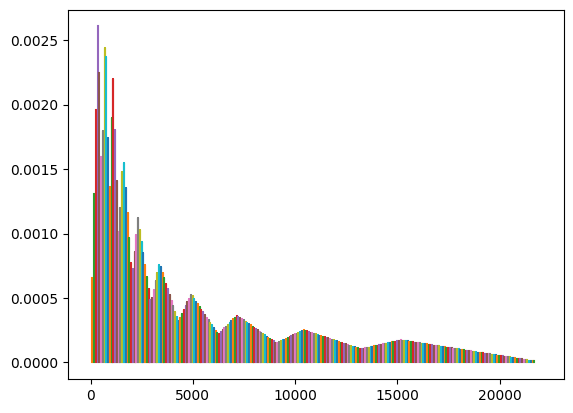

In [ ]:
import numpy.matlib
n_fft = 512
n = 10
mel_basis = librosa.filters.mel(sr=sample_rate, n_fft=n_fft, n_mels=n,fmin=0, fmax=sample_rate / 2)
f = np.linspace(0,int(sample_rate/2),int((n_fft/2)+1))
f_all = np.matlib.repmat(f, n,1)
plt.plot(f_all,mel_basis)
plt.show()

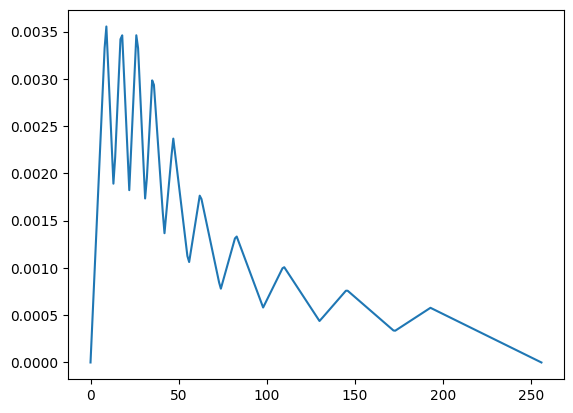

In [ ]:
mel_basis = librosa.filters.mel(sr=16000, n_fft=512, n_mels=10,fmin=0, fmax=16000 / 2)
mel_basis = np.max(mel_basis.T, axis=-1)[:, None]
plt.plot(mel_basis)

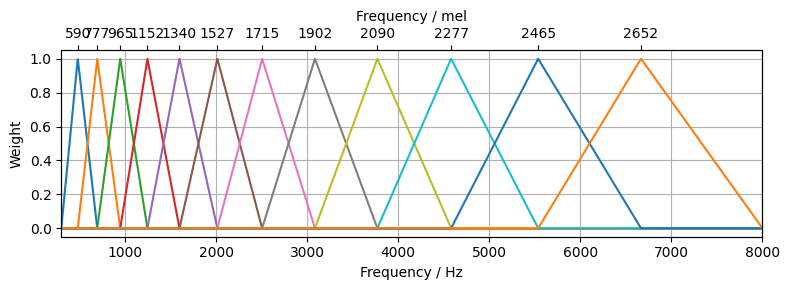

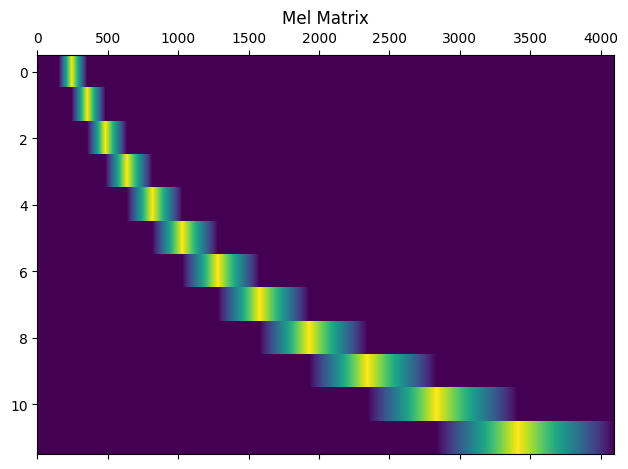

In [ ]:
from pylab import plt
from pyfilterbank import melbank

f1, f2 = 300, 8000
melmat, (melfreq, fftfreq) = melbank.compute_melmat(12, f1, f2, num_fft_bands=4097)
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(fftfreq, melmat.T)
ax.grid(True)
ax.set_ylabel('Weight')
ax.set_xlabel('Frequency / Hz')
ax.set_xlim((f1, f2))
ax2 = ax.twiny()
ax2.xaxis.set_ticks_position('top')
ax2.set_xlim((f1, f2))
ax2.xaxis.set_ticks(melbank.mel_to_hertz(melfreq))
ax2.xaxis.set_ticklabels(['{:.0f}'.format(mf) for mf in melfreq])
ax2.set_xlabel('Frequency / mel')
plt.tight_layout()

# fig, ax = plt.subplots()
# ax.matshow(melmat)
# plt.axis('equal')
# plt.axis('tight')
# plt.title('Mel Matrix')
# plt.tight_layout()

In [ ]:
fftfreq

array([0.00000000e+00, 1.95312500e+00, 3.90625000e+00, ...,
       7.99609375e+03, 7.99804688e+03, 8.00000000e+03])

In [ ]:
!{sys.executable} -m pip install git+https://github.com/SiggiGue/pyfilterbank.git

  Cloning https://github.com/SiggiGue/pyfilterbank.git to /tmp/pip-req-build-5kxyle_r
  Running command git clone --filter=blob:none --quiet https://github.com/SiggiGue/pyfilterbank.git /tmp/pip-req-build-5kxyle_r
  Resolved https://github.com/SiggiGue/pyfilterbank.git to commit 5d74af8d936d79dcb61f7f35a3120d79ea93480b
  Preparing metadata (setup.py) ... done
  Created wheel for pyfilterbank: filename=pyfilterbank-0.0.0-py3-none-any.whl size=67046 sha256=6e07bd8376049d4091042c0e76b25948a03aa90e1d5f6745660b8664632bd6e7
  Stored in directory: /tmp/pip-ephem-wheel-cache-rt4_1a5l/wheels/c3/09/94/e8a5bcdf405c5cf3a6230b00885055cc0af4e70d1f9dedf33b
Successfully built pyfilterbank


In [ ]:
import pyfilterbank.melbank

In [ ]:
fftfreq.shape

(4097,)

In [ ]:
melfreq.shape

(6,)

In [ ]:
melmat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
melfreq

array([444.21101463, 486.45144309, 528.69187155, 570.93230001,
       613.17272847, 655.41315694])

In [ ]:
"""This module implements a Mel Filter Bank.
In other words it is a filter bank with triangular shaped bands
arnged on the mel frequency scale.

An example ist shown in the following figure:

.. plot::

    from pylab import plt
    import melbank

    f1, f2 = 1000, 8000
    melmat, (melfreq, fftfreq) = melbank.compute_melmat(6, f1, f2, num_fft_bands=4097)
    fig, ax = plt.subplots(figsize=(8, 3))
    ax.plot(fftfreq, melmat.T)
    ax.grid(True)
    ax.set_ylabel('Weight')
    ax.set_xlabel('Frequency / Hz')
    ax.set_xlim((f1, f2))
    ax2 = ax.twiny()
    ax2.xaxis.set_ticks_position('top')
    ax2.set_xlim((f1, f2))
    ax2.xaxis.set_ticks(melbank.mel_to_hertz(melfreq))
    ax2.xaxis.set_ticklabels(['{:.0f}'.format(mf) for mf in melfreq])
    ax2.set_xlabel('Frequency / mel')
    plt.tight_layout()

    fig, ax = plt.subplots()
    ax.matshow(melmat)
    plt.axis('equal')
    plt.axis('tight')
    plt.title('Mel Matrix')
    plt.tight_layout()


Functions
---------
"""


from numpy import abs, append, arange, insert, linspace, log10, round, zeros


def hertz_to_mel(freq):
    """Returns mel-frequency from linear frequency input.

    Parameter
    ---------
    freq : scalar or ndarray
        Frequency value or array in Hz.

    Returns
    -------
    mel : scalar or ndarray
        Mel-frequency value or ndarray in Mel

    """
    return 2595.0 * log10(1 + (freq/700.0))


def mel_to_hertz(mel):
    """Returns frequency from mel-frequency input.

    Parameter
    ---------
    mel : scalar or ndarray
        Mel-frequency value or ndarray in Mel

    Returns
    -------
    freq : scalar or ndarray
        Frequency value or array in Hz.

    """
    return 700.0 * (10**(mel/2595.0)) - 700.0


def melfrequencies_mel_filterbank(num_bands, freq_min, freq_max, num_fft_bands):
    """Returns centerfrequencies and band edges for a mel filter bank
    Parameters
    ----------
    num_bands : int
        Number of mel bands.
    freq_min : scalar
        Minimum frequency for the first band.
    freq_max : scalar
        Maximum frequency for the last band.
    num_fft_bands : int
        Number of fft bands.

    Returns
    -------
    center_frequencies_mel : ndarray
    lower_edges_mel : ndarray
    upper_edges_mel : ndarray

    """

    mel_max = hertz_to_mel(freq_max)
    mel_min = hertz_to_mel(freq_min)
    delta_mel = abs(mel_max - mel_min) / (num_bands + 1.0)
    frequencies_mel = mel_min + delta_mel*arange(0, num_bands+2)
    lower_edges_mel = frequencies_mel[:-2]
    upper_edges_mel = frequencies_mel[2:]
    center_frequencies_mel = frequencies_mel[1:-1]

    return center_frequencies_mel, lower_edges_mel, upper_edges_mel


def compute_melmat(num_mel_bands=12, freq_min=64, freq_max=8000,
                   num_fft_bands=513, sample_rate=16000):
    """Returns tranformation matrix for mel spectrum.

    Parameters
    ----------
    num_mel_bands : int
        Number of mel bands. Number of rows in melmat.
        Default: 24
    freq_min : scalar
        Minimum frequency for the first band.
        Default: 64
    freq_max : scalar
        Maximum frequency for the last band.
        Default: 8000
    num_fft_bands : int
        Number of fft-frequenc bands. This ist NFFT/2+1 !
        number of columns in melmat.
        Default: 513   (this means NFFT=1024)
    sample_rate : scalar
        Sample rate for the signals that will be used.
        Default: 44100

    Returns
    -------
    melmat : ndarray
        Transformation matrix for the mel spectrum.
        Use this with fft spectra of num_fft_bands_bands length
        and multiply the spectrum with the melmat
        this will tranform your fft-spectrum
        to a mel-spectrum.

    frequencies : tuple (ndarray <num_mel_bands>, ndarray <num_fft_bands>)
        Center frequencies of the mel bands, center frequencies of fft spectrum.

    """
    center_frequencies_mel, lower_edges_mel, upper_edges_mel =  \
        melfrequencies_mel_filterbank(
            num_mel_bands,
            freq_min,
            freq_max,
            num_fft_bands
    )

    len_fft = float(num_fft_bands) / sample_rate
    center_frequencies_hz = mel_to_hertz(center_frequencies_mel)
    lower_edges_hz = mel_to_hertz(lower_edges_mel)
    upper_edges_hz = mel_to_hertz(upper_edges_mel)
    freqs = linspace(0.0, sample_rate/2.0, num_fft_bands)
    melmat = zeros((num_mel_bands, num_fft_bands))
    print(lower_edges_hz)
    print(upper_edges_hz)
    print(center_frequencies_hz)


    for imelband, (center, lower, upper) in enumerate(zip(
            center_frequencies_hz, lower_edges_hz, upper_edges_hz)):

        left_slope = (freqs >= lower)  == (freqs <= center)
        melmat[imelband, left_slope] = (
            (freqs[left_slope] - lower) / (center - lower)
        )

        right_slope = (freqs >= center) == (freqs <= upper)
        melmat[imelband, right_slope] = (
            (upper - freqs[right_slope]) / (upper - center)
        )

    return melmat, (center_frequencies_mel, freqs)


[ 300.          481.05660231  694.89469787  947.44959245 1245.73121814
 1598.01870151 2014.09015966 2505.49410234 3085.86997324 3771.3267274
 4580.88995249 5537.02994448]
[ 694.89469787  947.44959245 1245.73121814 1598.01870151 2014.09015966
 2505.49410234 3085.86997324 3771.3267274  4580.88995249 5537.02994448
 6666.28539476 8000.        ]
[ 481.05660231  694.89469787  947.44959245 1245.73121814 1598.01870151
 2014.09015966 2505.49410234 3085.86997324 3771.3267274  4580.88995249
 5537.02994448 6666.28539476]


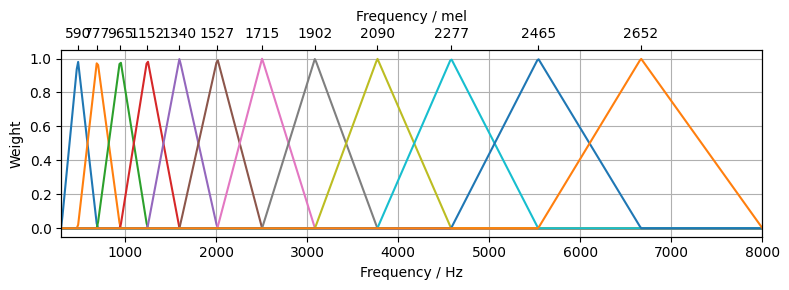

In [ ]:
f1, f2 = 300, 8000
melmat, (melfreq, fftfreq) = compute_melmat(12, f1, f2, num_fft_bands=512)
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(fftfreq, melmat.T)
ax.grid(True)
ax.set_ylabel('Weight')
ax.set_xlabel('Frequency / Hz')
ax.set_xlim((f1, f2))
ax2 = ax.twiny()
ax2.xaxis.set_ticks_position('top')
ax2.set_xlim((f1, f2))
ax2.xaxis.set_ticks(mel_to_hertz(melfreq))
ax2.xaxis.set_ticklabels(['{:.0f}'.format(mf) for mf in melfreq])
ax2.set_xlabel('Frequency / mel')
plt.tight_layout()

In [ ]:
fftfreq[3000:3020]

array([5859.375   , 5861.328125, 5863.28125 , 5865.234375, 5867.1875  ,
       5869.140625, 5871.09375 , 5873.046875, 5875.      , 5876.953125,
       5878.90625 , 5880.859375, 5882.8125  , 5884.765625, 5886.71875 ,
       5888.671875, 5890.625   , 5892.578125, 5894.53125 , 5896.484375])

In [ ]:
melmat.shape

(12, 512)

[2000.         2060.53417436 2122.42552883 2185.70449145 2250.40217251
 2316.55037975 2384.18163407 2453.32918548 2524.02702946 2596.30992366
 2670.21340503 2745.77380721 2823.02827849 2902.01480001 2982.77220444
 3065.3401951  3149.75936544 3236.07121902 3324.31818994 3414.54366365
 3506.7919983  3601.10854657 3697.53967795 3796.13280152]
[2122.42552883 2185.70449145 2250.40217251 2316.55037975 2384.18163407
 2453.32918548 2524.02702946 2596.30992366 2670.21340503 2745.77380721
 2823.02827849 2902.01480001 2982.77220444 3065.3401951  3149.75936544
 3236.07121902 3324.31818994 3414.54366365 3506.7919983  3601.10854657
 3697.53967795 3796.13280152 3896.93638929 4000.        ]
[2060.53417436 2122.42552883 2185.70449145 2250.40217251 2316.55037975
 2384.18163407 2453.32918548 2524.02702946 2596.30992366 2670.21340503
 2745.77380721 2823.02827849 2902.01480001 2982.77220444 3065.3401951
 3149.75936544 3236.07121902 3324.31818994 3414.54366365 3506.7919983
 3601.10854657 3697.53967795 3796.

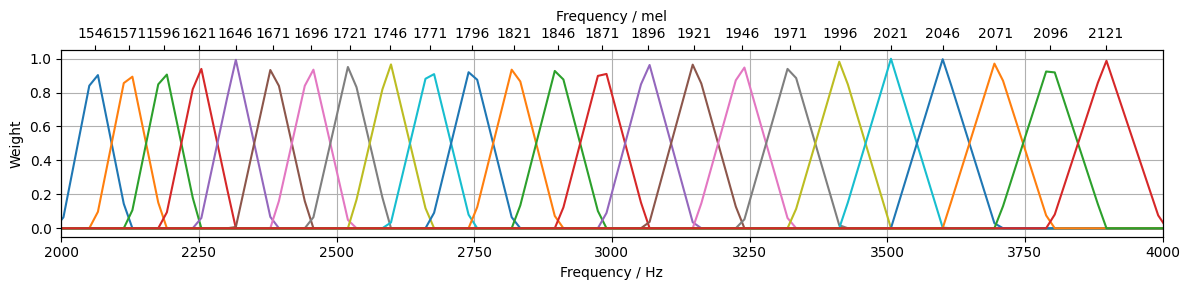

In [ ]:
f11, f22 = 2000, 4000
melmat1, (melfreq1, fftfreq1) = compute_melmat(24, f11, f22, num_fft_bands=512)
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(fftfreq1, melmat1.T)
ax.grid(True)
ax.set_ylabel('Weight')
ax.set_xlabel('Frequency / Hz')
ax.set_xlim((f11, f22))
ax2 = ax.twiny()
ax2.xaxis.set_ticks_position('top')
ax2.set_xlim((f11, f22))
ax2.xaxis.set_ticks(mel_to_hertz(melfreq1))
ax2.xaxis.set_ticklabels(['{:.0f}'.format(mf) for mf in melfreq1])
ax2.set_xlabel('Frequency / mel')
plt.tight_layout()

In [ ]:
melmat1

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
melfreq1

array([1546.34775309, 1571.33595202, 1596.32415096, 1621.31234989,
       1646.30054883, 1671.28874776, 1696.27694669, 1721.26514563,
       1746.25334456, 1771.2415435 , 1796.22974243, 1821.21794136,
       1846.2061403 , 1871.19433923, 1896.18253817, 1921.1707371 ,
       1946.15893603, 1971.14713497, 1996.1353339 , 2021.12353284,
       2046.11173177, 2071.0999307 , 2096.08812964, 2121.07632857])

In [ ]:
melfreq

array([ 589.51308313,  777.05558009,  964.59807706, 1152.14057402,
       1339.68307099, 1527.22556795, 1714.76806492, 1902.31056188,
       2089.85305885, 2277.39555581, 2464.93805278, 2652.48054974])

In [ ]:
np.concatenate([melfreq[0:6], melfreq1, melfreq[9:]])

array([ 589.51308313,  777.05558009,  964.59807706, 1152.14057402,
       1339.68307099, 1527.22556795, 1546.34775309, 1571.33595202,
       1596.32415096, 1621.31234989, 1646.30054883, 1671.28874776,
       1696.27694669, 1721.26514563, 1746.25334456, 1771.2415435 ,
       1796.22974243, 1821.21794136, 1846.2061403 , 1871.19433923,
       1896.18253817, 1921.1707371 , 1946.15893603, 1971.14713497,
       1996.1353339 , 2021.12353284, 2046.11173177, 2071.0999307 ,
       2096.08812964, 2121.07632857, 2277.39555581, 2464.93805278,
       2652.48054974])

In [ ]:
melfreq

array([ 589.51308313,  777.05558009,  964.59807706, 1152.14057402,
       1339.68307099, 1527.22556795, 1714.76806492, 1902.31056188,
       2089.85305885, 2277.39555581, 2464.93805278, 2652.48054974])

In [ ]:
melmat.shape

(12, 512)

In [ ]:
melmat1.shape

(24, 512)

In [ ]:
def hz2mel(hz):
    """Convert a value in Hertz to Mels
    :param hz: a value in Hz. This can also be a numpy array, conversion proceeds element-wise.
    :returns: a value in Mels. If an array was passed in, an identical sized array is returned.
    """
    return 2595 * np.log10(1+hz/700.)

def mel2hz(mel):
    """Convert a value in Mels to Hertz
    :param mel: a value in Mels. This can also be a numpy array, conversion proceeds element-wise.
    :returns: a value in Hertz. If an array was passed in, an identical sized array is returned.
    """
    return 700*(10**(mel/2595.0)-1)

def get_filterbanks(nfilt=20,nfft=512,samplerate=16000,lowfreq=0,highfreq=None):
    """Compute a Mel-filterbank. The filters are stored in the rows, the columns correspond
    to fft bins. The filters are returned as an array of size nfilt * (nfft/2 + 1)
    :param nfilt: the number of filters in the filterbank, default 20.
    :param nfft: the FFT size. Default is 512.
    :param samplerate: the sample rate of the signal we are working with, in Hz. Affects mel spacing.
    :param lowfreq: lowest band edge of mel filters, default 0 Hz
    :param highfreq: highest band edge of mel filters, default samplerate/2
    :returns: A numpy array of size nfilt * (nfft/2 + 1) containing filterbank. Each row holds 1 filter.
    """
    highfreq= highfreq or samplerate/2
    assert highfreq <= samplerate/2, "highfreq is greater than samplerate/2"

    # compute points evenly spaced in mels
    lowmel = hz2mel(lowfreq)
    highmel = hz2mel(highfreq)
    melpoints = np.linspace(lowmel,highmel,nfilt+2)
    # our points are in Hz, but we use fft bins, so we have to convert
    #  from Hz to fft bin number
    bin = np.floor((nfft+1)*mel2hz(melpoints)/samplerate)

    fbank = np.zeros([nfilt,nfft//2+1])
    for j in range(0,nfilt):
        for i in range(int(bin[j]), int(bin[j+1])):
            fbank[j,i] = (i - bin[j]) / (bin[j+1]-bin[j])
        for i in range(int(bin[j+1]), int(bin[j+2])):
            fbank[j,i] = (bin[j+2]-i) / (bin[j+2]-bin[j+1])
    return fbank, bin, melpoints


In [ ]:
b

array([ 1.,  1.,  2.,  2.,  3.,  4.,  4.,  5.,  6.,  6.,  7.,  8.,  9.,
       10., 11.])

In [ ]:
x = get_filterbanks(nfilt=12,nfft=512,samplerate=16000,lowfreq=300,highfreq=8000)
y, _ = compute_melmat(12, 300, 800, num_fft_bands=257, sample_rate = 16000)

[300.         331.68111653 364.36592621 398.08622715 432.87482487
 468.76556421 505.79336225 543.99424227 583.40536882 624.06508387
 666.01294408 709.28975935]
[364.36592621 398.08622715 432.87482487 468.76556421 505.79336225
 543.99424227 583.40536882 624.06508387 666.01294408 709.28975935
 753.93763244 800.        ]
[331.68111653 364.36592621 398.08622715 432.87482487 468.76556421
 505.79336225 543.99424227 583.40536882 624.06508387 666.01294408
 709.28975935 753.93763244]


In [ ]:
lowmel = hz2mel(300)
highmel = hz2mel(8000)
melpoints = np.linspace(lowmel,highmel,12)

In [ ]:
np.linspace(lowmel,highmel,12)

array([ 401.97058616,  623.61171894,  845.25285172, 1066.89398449,
       1288.53511727, 1510.17625005, 1731.81738282, 1953.4585156 ,
       2175.09964838, 2396.74078115, 2618.38191393, 2840.02304671])

In [ ]:
np.linspace(lowmel,highmel,14)

array([ 401.97058616,  589.51308313,  777.05558009,  964.59807706,
       1152.14057402, 1339.68307099, 1527.22556795, 1714.76806492,
       1902.31056188, 2089.85305885, 2277.39555581, 2464.93805278,
       2652.48054974, 2840.02304671])

In [ ]:
melpoints.shape

(12,)

In [ ]:
a,b,c = get_filterbanks(nfilt=13,nfft=512,samplerate=44100,lowfreq=100,highfreq=1000)

In [ ]:
d,e,f = get_filterbanks(nfilt=18,nfft=512,samplerate=44100,lowfreq=333,highfreq=666)

In [ ]:
c

array([150.48910241, 211.16741917, 271.84573594, 332.52405271,
       393.20236947, 453.88068624, 514.55900301, 575.23731977,
       635.91563654, 696.59395331, 757.27227007, 817.95058684,
       878.62890361, 939.30722037, 999.98553714])

In [ ]:
f

array([438.56092051, 455.13482737, 471.70873424, 488.28264111,
       504.85654797, 521.43045484, 538.0043617 , 554.57826857,
       571.15217544, 587.7260823 , 604.29998917, 620.87389603,
       637.4478029 , 654.02170977, 670.59561663, 687.1695235 ,
       703.74343037, 720.31733723, 736.8912441 , 753.46515096])

In [ ]:
b

array([  9.,  15.,  22.,  30.,  39.,  51.,  64.,  80.,  98., 120., 146.,
       177., 213., 256.])

In [ ]:
e

array([ 64.,  66.,  68.,  70.,  72.,  74.,  76.,  78.,  80.,  83.,  85.,
        88.,  90.,  93.,  95.,  98., 100., 103., 106., 109., 112., 115.,
       118., 121., 124., 128.])

In [ ]:
f

array([1521.35955416, 1546.34775309, 1571.33595202, 1596.32415096,
       1621.31234989, 1646.30054883, 1671.28874776, 1696.27694669,
       1721.26514563, 1746.25334456, 1771.2415435 , 1796.22974243,
       1821.21794136, 1846.2061403 , 1871.19433923, 1896.18253817,
       1921.1707371 , 1946.15893603, 1971.14713497, 1996.1353339 ,
       2021.12353284, 2046.11173177, 2071.0999307 , 2096.08812964,
       2121.07632857, 2146.06452751])

In [ ]:
c.shape

(14,)

In [ ]:
np.concatenate([c[0:6], f, c[10:]])

array([ 401.97058616,  589.51308313,  777.05558009,  964.59807706,
       1152.14057402, 1339.68307099, 1521.35955416, 1546.34775309,
       1571.33595202, 1596.32415096, 1621.31234989, 1646.30054883,
       1671.28874776, 1696.27694669, 1721.26514563, 1746.25334456,
       1771.2415435 , 1796.22974243, 1821.21794136, 1846.2061403 ,
       1871.19433923, 1896.18253817, 1921.1707371 , 1946.15893603,
       1971.14713497, 1996.1353339 , 2021.12353284, 2046.11173177,
       2071.0999307 , 2096.08812964, 2121.07632857, 2146.06452751,
       2277.39555581, 2464.93805278, 2652.48054974, 2840.02304671])

In [ ]:
sum(x != a)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
x[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.16666667, 0.33333333, 0.5       , 0.66666667, 0.83333333,
       1.        , 0.85714286, 0.71428571, 0.57142857, 0.42857143,
       0.28571429, 0.14285714, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [ ]:
y[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.3945568 , 0.63074946, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

[100.         144.25330223 190.95454791 240.23914901 292.25000805
 347.13793242 405.06207167 466.19037897 530.70009809 598.77827734
 670.62231188 746.44051615 826.4527278 ]
[ 190.95454791  240.23914901  292.25000805  347.13793242  405.06207167
  466.19037897  530.70009809  598.77827734  670.62231188  746.44051615
  826.4527278   910.89094518 1000.        ]
[144.25330223 190.95454791 240.23914901 292.25000805 347.13793242
 405.06207167 466.19037897 530.70009809 598.77827734 670.62231188
 746.44051615 826.4527278  910.89094518]


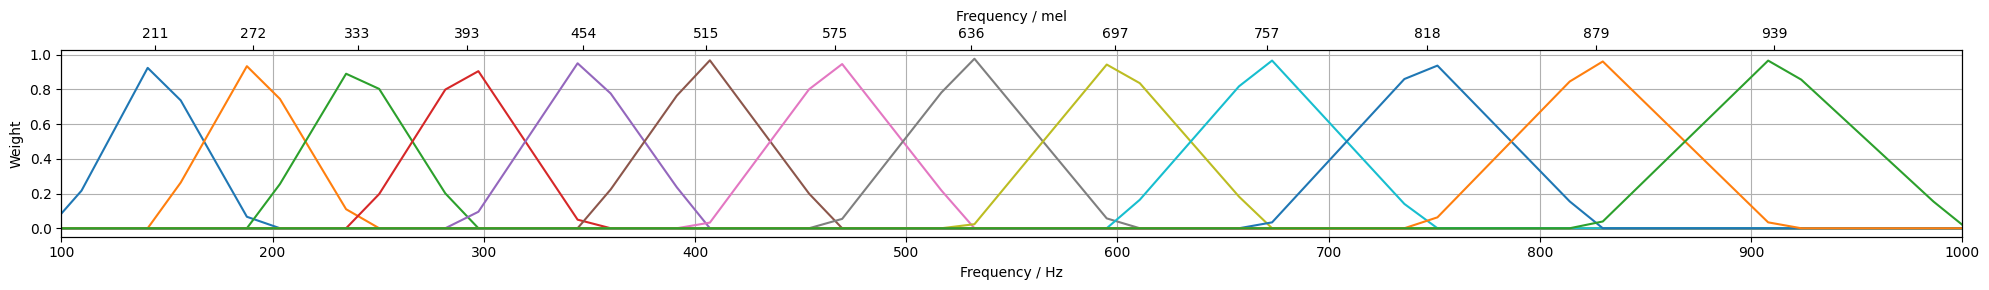

In [ ]:
f1, f2 = 100, 1000
melmat1, (melfreq1, fftfreq1) = compute_melmat(13, f1, f2, num_fft_bands=512)
# melmat, (melfreq, fftfreq) = compute_melmat(24, f11, f22, num_fft_bands=512)
melfreq_combined = melfreq1
melmat_combined = melmat1

# melfreq_combined = np.concatenate([melfreq[0:6], melfreq1, melfreq[9:]])
# melmat_combined = np.concatenate([melmat[0:6], melmat1, melmat[9:]])
fig, ax = plt.subplots(figsize=(20, 3))
ax.plot(fftfreq1, melmat_combined.T)
ax.grid(True)
ax.set_ylabel('Weight')
ax.set_xlabel('Frequency / Hz')
ax.set_xlim((f1, f2))
ax2 = ax.twiny()
ax2.xaxis.set_ticks_position('top')
ax2.set_xlim((f1, f2))
ax2.xaxis.set_ticks(mel_to_hertz(melfreq_combined))
ax2.xaxis.set_ticklabels(['{:.0f}'.format(mf) for mf in melfreq_combined])
ax2.set_xlabel('Frequency / mel')
plt.tight_layout()

In [ ]:
a,b,c = get_filterbanks(nfilt=13,nfft=512,samplerate=44100,lowfreq=100,highfreq=1000)
d,e,f = get_filterbanks(nfilt=18,nfft=512,samplerate=44100,lowfreq=333,highfreq=666)

In [ ]:
c

array([150.48910241, 211.16741917, 271.84573594, 332.52405271,
       393.20236947, 453.88068624, 514.55900301, 575.23731977,
       635.91563654, 696.59395331, 757.27227007, 817.95058684,
       878.62890361, 939.30722037, 999.98553714])

In [ ]:
f

array([438.56092051, 455.13482737, 471.70873424, 488.28264111,
       504.85654797, 521.43045484, 538.0043617 , 554.57826857,
       571.15217544, 587.7260823 , 604.29998917, 620.87389603,
       637.4478029 , 654.02170977, 670.59561663, 687.1695235 ,
       703.74343037, 720.31733723, 736.8912441 , 753.46515096])

In [ ]:
np.concatenate([c[0:6], f, c[10:]])

In [ ]:
c

array([150.48910241, 211.16741917, 271.84573594, 332.52405271,
       393.20236947, 453.88068624, 514.55900301, 575.23731977,
       635.91563654, 696.59395331, 757.27227007, 817.95058684,
       878.62890361, 939.30722037, 999.98553714])

In [ ]:
[mel2hz(x) for x in c]

[99.99999999999996,
 144.25330223050494,
 190.9545479088906,
 240.2391490117094,
 292.2500080494195,
 347.1379324174594,
 405.0620716678294,
 466.19037896906,
 530.7000980925912,
 598.7782773375958,
 670.6223118843901,
 746.440516149007,
 826.4527277984939,
 910.8909451783009,
 1000.0000000000002]

In [ ]:
np.linspace(hz2mel(100),hz2mel(1000), 13)

array([150.48910241, 221.28047197, 292.07184153, 362.86321109,
       433.65458065, 504.44595021, 575.23731977, 646.02868933,
       716.8200589 , 787.61142846, 858.40279802, 929.19416758,
       999.98553714])

In [ ]:
np.linspace(hz2mel(333),hz2mel(666), 13)[-1]

753.4651509646117

In [ ]:
[1,2,3,4,5,6,7,8,9][:4]

[1, 2, 3, 4]

In [ ]:
filter_range_1 = [0,1,2,3,4,5,6,7,8,9,10]
filter_range_2 = [3.25, 3.5, 3.75, 4.25, 4.75, 5.10, 5.45, 6.2]
for i, val in enumerate(filter_range_1):
    if val >= filter_range_2[0]:
        first_index = i
        break

for i, val in enumerate(filter_range_1):
    if val > filter_range_2[-1]:
        second_index = i
        break

In [ ]:
second_index

7

In [ ]:
[0,1,2,3,4,5,6,7,8,9,10][:first_index]

[0, 1, 2, 3]

In [ ]:
[1,2,3,4,5,6,7,8,9]
[5, 5.5, 6, 6.5, 7, 7.5, 8]

In [ ]:
sr, y = wavfile.read('./data/sample_arteri/sample_arteri_2a_filt1k5.wav')

/home/ec2-user/anaconda3/envs/call_analysis/lib/python3.7/site-packages/ipykernel/__main__.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  if __name__ == "__main__":


In [ ]:
mfcc(y,samplerate=16000,numcep=13,nfilt=13,nfft=512).shape

(21, 257)


(171, 13)

In [ ]:
y

array([  -5,   -5,   -5, ..., -251, -133,  -40], dtype=int16)

In [ ]:
np.concatenate

In [ ]:
melmat_combined.shape

(33, 512)

In [ ]:
a = [1,2,3,4]
b = [2.5, 2.75]

In [ ]:
a.insert(2, b[0])

In [ ]:
a.insert(3, b[1])

In [ ]:
a

[1, 2, 2.5, 2.75, 3, 4]

In [ ]:
melmat.shape

(12, 512)

In [ ]:
melmat1.shape

(24, 512)

In [ ]:
melfreq1

array([1546.34775309, 1571.33595202, 1596.32415096, 1621.31234989,
       1646.30054883, 1671.28874776, 1696.27694669, 1721.26514563,
       1746.25334456, 1771.2415435 , 1796.22974243, 1821.21794136,
       1846.2061403 , 1871.19433923, 1896.18253817, 1921.1707371 ,
       1946.15893603, 1971.14713497, 1996.1353339 , 2021.12353284,
       2046.11173177, 2071.0999307 , 2096.08812964, 2121.07632857])

In [ ]:
fbank(signal,samplerate=16000,winlen=0.025,winstep=0.01,
          nfilt=26,nfft=512,lowfreq=0,highfreq=None,preemph=0.97,
          winfunc=lambda x:numpy.ones((x,)))